In [1]:
import numpy as np
import torch
from torchdyn.models import NeuralODE
import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/fei/Documents/UCL/Thesis/Code/MBRL_HNN')
sys.path.append('/Users/fei/Documents/UCL/Thesis/Code/MBRL_HNN/ilqr')

from ilqr.cost import QRCost
from ilqr.cartpole import PendulumDynamic, GeneralDyanmic
from ilqr.dynamic import constrain, tensor_constrain
from ilqr.controller import iLQR

# from cost import QRCost
# from cartpole import PendulumDynamic, GeneralDyanmic
# from dynamic import constrain, tensor_constrain
# from controller import iLQR

from gym_env import PendulumCustomEnv
from gym.wrappers import Monitor

In [2]:
np.set_printoptions(suppress=True)
np.random.seed(0)
device = 'cpu'

# env init
env_inside = PendulumCustomEnv()
env = Monitor(env_inside, './data/', force=True)

init_state = np.array([np.pi, 0.])
goal_state = np.array([0., 0.])
obs0, _ = env.reset(init_state)
env.seed(0)

/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[0]

In [3]:
dt = 0.05
grad = NeuralODE(PendulumDynamic().to(device), sensitivity='adjoint', solver='rk4')
dynamics = GeneralDyanmic(0.05, grad, state_size=3, action_size=1)

In [4]:
x0 = PendulumDynamic.augment_state(init_state)
x_goal = PendulumDynamic.augment_state(goal_state)

Q = np.eye(dynamics.state_size)
Q[2, 2] = 0.0
Q_terminal = 100. * np.eye(dynamics.state_size)
R = np.array([[0.1]])
cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [5]:
print(x0)
print(obs0)
print(x_goal)
print(Q)

[-1.  0.  0.]
[-1. -0.  0.]
[1. 0. 0.]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]


# Create better inital solution

In [6]:
total_N = 150
partial_N = 10
start_N = 100

In [7]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    info = "converged" if converged else ("accepted" if accepted else "failed")
    if converged:
        final_state = PendulumDynamic.reduce_state(xs[-1])
        print("iteration", iteration_count, info, J_opt, final_state, us[:2, 0])

iteration 34 converged 424.36331590918957 [-2.70818565  0.05706573] [2.11006365 2.08241544]
10


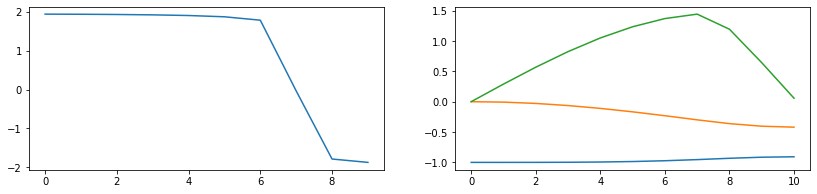

iteration 37 converged 410.73550175587764 [ 2.25263379 -0.01997423] [1.92795709 1.5961383 ]
20


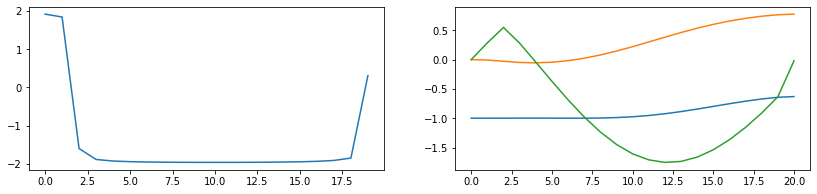

iteration 30 converged 307.97197659241107 [-1.49844684  0.07744956] [-2.51343329 -2.5354497 ]
30


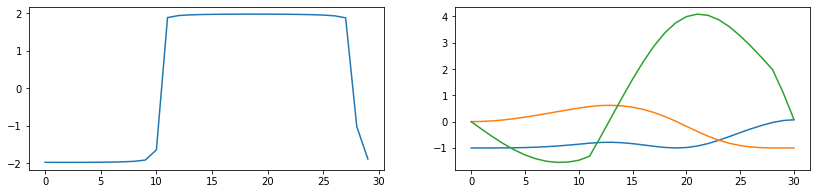

40


/Users/fei/Documents/UCL/Thesis/Code/MBRL_HNN/ilqr/controller.py:171: UserWarning: exceeded max regularization term
  warnings.warn("exceeded max regularization term")


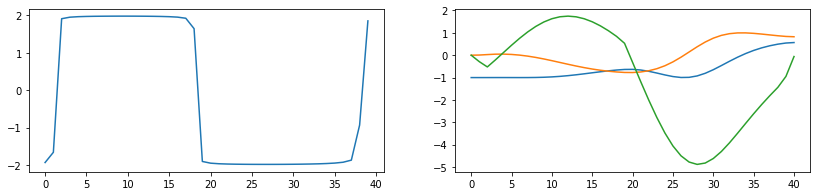

iteration 41 converged 163.74032080741898 [-0.17984357  0.03490424] [2.10241574 2.04751983]
50


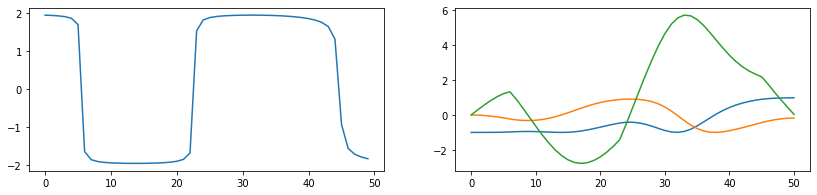

iteration 33 converged 158.1687450140227 [-0.00423587  0.0012548 ] [1.89908667 1.84321165]
60


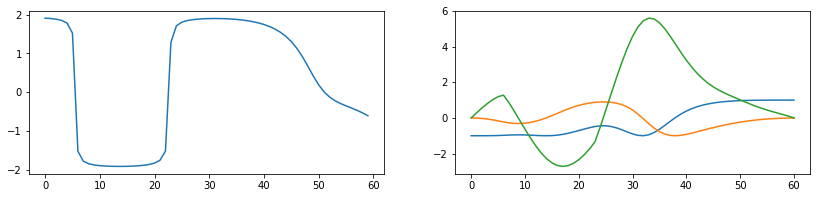

70


/Users/fei/Documents/UCL/Thesis/Code/MBRL_HNN/ilqr/controller.py:171: UserWarning: exceeded max regularization term
  warnings.warn("exceeded max regularization term")


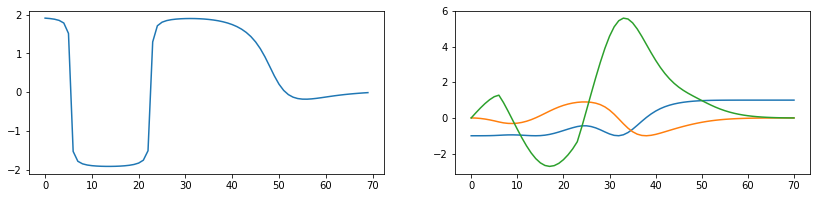

iteration 27 converged 158.14598778087154 [ 0.0000714  -0.00001295] [1.89643081 1.8401724 ]
80


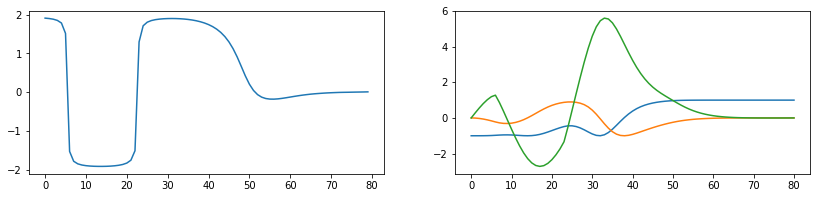

iteration 8 converged 158.1459910504827 [ 0.00000451 -0.0000014 ] [1.89667318 1.84048148]
90


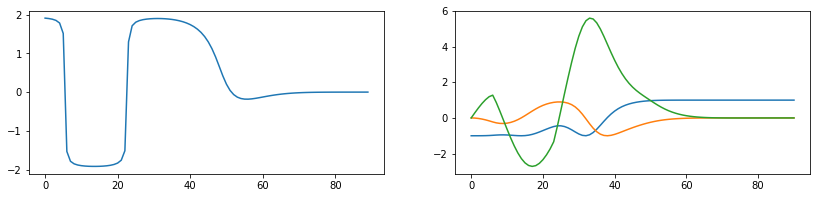

iteration 22 converged 158.14598904493914 [-0.0000009  -0.00000046] [1.89652045 1.84032946]
100


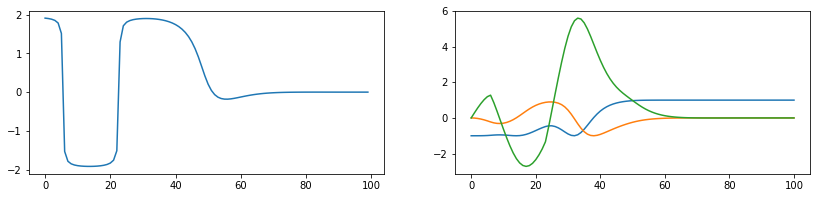

iteration 5 converged 158.1460077927927 [-0.00000282  0.00000047] [1.8964949  1.84034201]
110


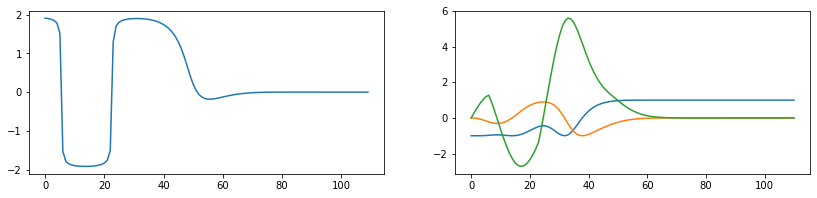

iteration 8 converged 158.14600614028507 [-0.00000001  0.        ] [1.89690124 1.84075631]
120


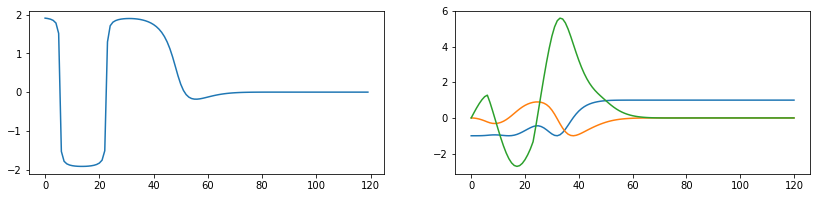

iteration 24 converged 158.1459923952555 [0.00000022 0.        ] [1.89653401 1.84040347]
130


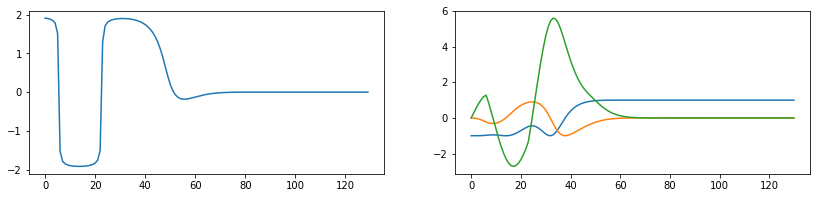

iteration 2 converged 158.14642403652758 [-0.00016311 -0.00000231] [1.89502226 1.83840964]
140


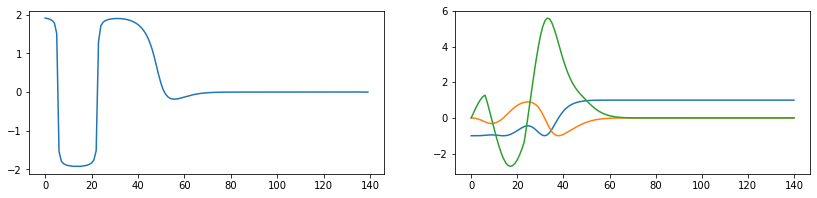

iteration 34 converged 158.146005867708 [-0.  0.] [1.8964712  1.84029077]


In [8]:
np.random.seed(0)
us_init = np.random.uniform(-1, 1, (start_N, dynamics.action_size))

cur_x0 = x0
cur_us = us_init
for N in np.arange(start_N, total_N+1, partial_N):
    # Generate the optimiser and initial guess
    ilqr = iLQR(dynamics, cost, N)
    xs, us = ilqr.fit(x0, cur_us, n_iterations=500, on_iteration=on_iteration)
    
    if N == total_N:
        break

    new_us = np.random.uniform(-1, 1, (partial_N, dynamics.action_size))
    cur_us = np.vstack([us, new_us])
    
    print(N)
    
    fig = plt.figure(figsize=(14, 3))
    plt.subplots_adjust(hspace=0.4)

    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.plot(constrain(us, -2, 2))
    ax2.plot(xs)
    plt.show()

In [9]:
xs_recover = PendulumDynamic.reduce_state(xs)
us_constrain = constrain(us, -2.,  2.)

t = np.arange(N) * dt
theta = np.unwrap(xs_recover[:, 0])  # Makes for smoother plots.
theta_dot = xs_recover[:, 1]

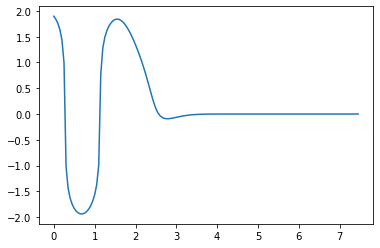

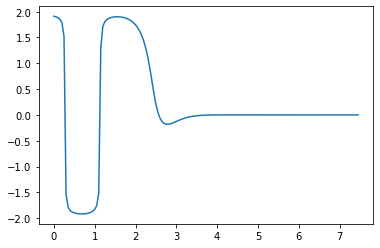

In [10]:
plt.plot(t, us)
plt.show()
plt.plot(t, us_constrain)
plt.show()

In [11]:
obs0, _ = env.reset(init_state)
action = us_constrain[0]

all_obs = []
all_obs.append(obs0)
for i in range(total_N):
    next_obs, reward, done, info = env.step(us_constrain[i])
    all_obs.append(next_obs)
env.close()

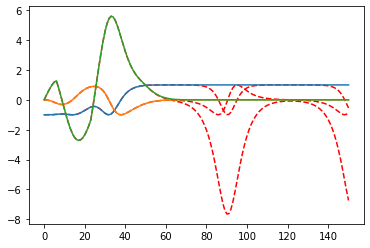

In [12]:
plt.plot(all_obs, 'r--')
plt.plot(xs)
plt.show()

# Step in the env by one step

In [13]:
# one step in env
obs0, _ = env.reset(init_state)

In [14]:
print(us.shape)

(150, 1)


In [15]:
next_obs, reward, done, info = env.step(us_constrain[0])

In [16]:
print(next_obs)
print(xs[1])
# Small difference between prediction and estimation

[-0.99997446 -0.00714749  0.28502522]
[-0.99997443 -0.00714746  0.28502262]


In [17]:
total_N

150

In [18]:
xs[0]

array([-1.,  0.,  0.])

In [19]:
# optimise again
steps = 1
print(xs[1, :])
print(next_obs)
test = xs[1, :].copy()
test[1] += 0.01
test[2] += 0.01
print(test)

[-0.99997443 -0.00714746  0.28502262]
[-0.99997446 -0.00714749  0.28502522]
[-0.99997443  0.00285254  0.29502262]


In [20]:
ilqr = iLQR(dynamics, cost, 50)
xs1, us1 = ilqr.fit(test, us[1:51], n_iterations=100, on_iteration=on_iteration)

iteration 26 converged 157.55508851718565 [-0.13346728  0.02690321] [2.00640663 1.92911069]


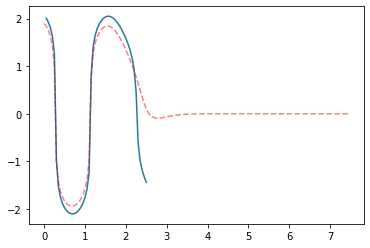

In [21]:
plt.plot(t[1:51], us1)
plt.plot(t, us ,'r--', alpha=0.5)

iteration 20 converged 1.3188232511956497 [-2.98532116  1.16085577] [1.4151412  1.47656443]
[-0.9878149  -0.1556363   1.16085577] [-0.99997793 -0.0066439   0.26494285]


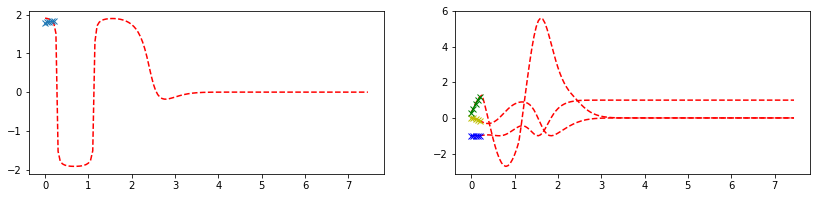

iteration 12 converged 1.130528268859449 [-2.92968721  1.25661373] [1.30254087 1.34819812]
[-0.97763264 -0.21032326  1.25661373] [-0.99965847 -0.02613324  0.51235617]


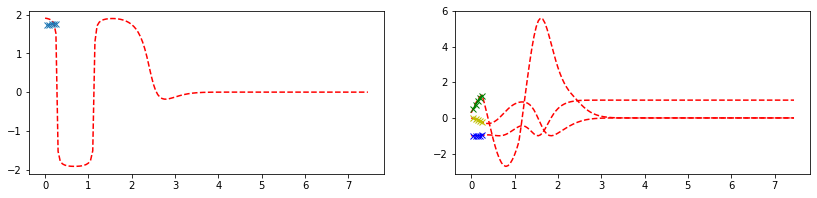

iteration 13 converged 0.6071595604853903 [-2.90254749  0.86331832] [1.00598737 0.90376698]
[-0.97156477 -0.23677512  0.86331832] [-0.99838554 -0.05680073  0.71168452]


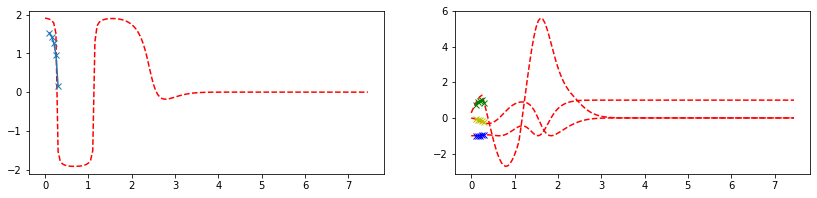

iteration 10 converged 0.597666670056835 [-2.87795536  0.38379163] [0.9568079  0.74271489]
[-0.96544808 -0.26059377  0.38379163] [-0.99532713 -0.09656034  0.87862481]


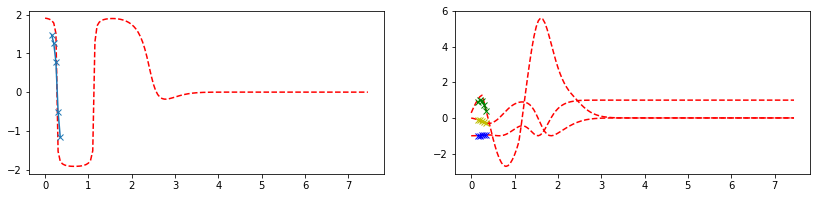

iteration 22 converged 0.6646051397175534 [-2.87786715 -0.11792472] [0.79604372 0.3688817 ]
[-0.9654246  -0.2606788  -0.11792472] [-0.98971398 -0.14306029  0.98934116]


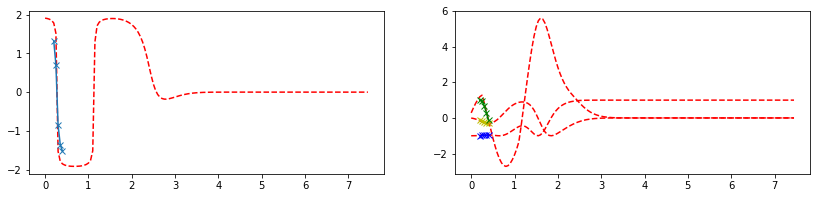

iteration 11 converged 0.8581669808388521 [-2.90375873 -0.61767757] [ 0.37500008 -0.61614178]
[-0.9718495  -0.23559782 -0.61767757] [-0.981476   -0.19158511  0.97366845]


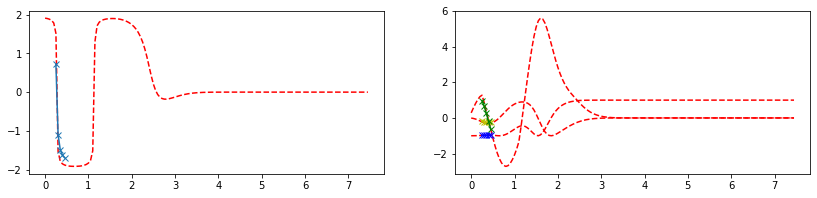

iteration 14 converged 1.2606084722562567 [-2.95483357 -1.09425354] [-0.7347266 -1.0879586]
[-0.98261023 -0.18567514 -1.09425354] [-0.97298395 -0.23087278  0.62941935]


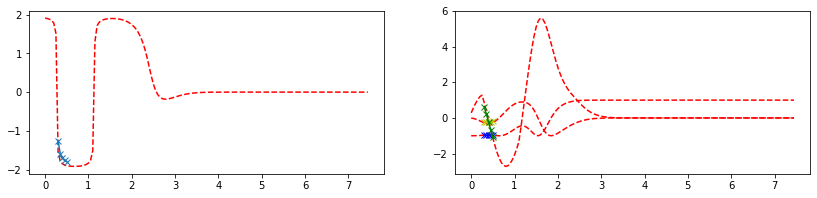

iteration 14 converged 1.864946762733989 [-3.02653091 -1.52483892] [-1.2554791  -1.43188831]
[-0.9933877  -0.11480802 -1.52483892] [-0.96799797 -0.25095801  0.19592543]


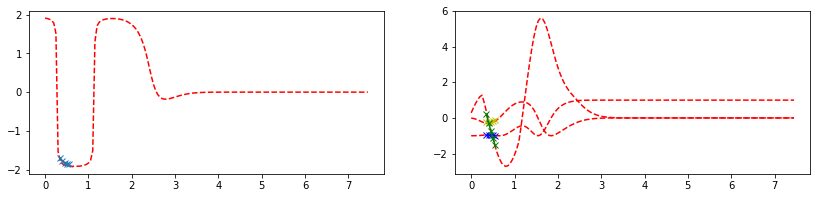

iteration 11 converged 2.700768605851029 [-3.11557922 -1.88812494] [-1.58593036 -1.70968088]
[-0.99966264 -0.02601052 -1.88812494] [-0.96843321 -0.2492732  -0.26532355]


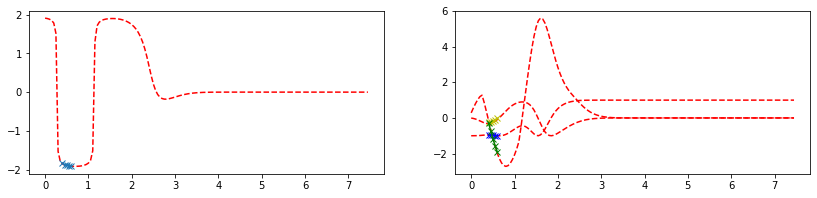

iteration 7 converged 3.8180921834633024 [ 3.06420383 -2.172153  ] [-1.81018008 -1.91295764]
[-0.9970088   0.07731174 -2.172153  ] [-0.97432726 -0.2251364  -0.72558211]


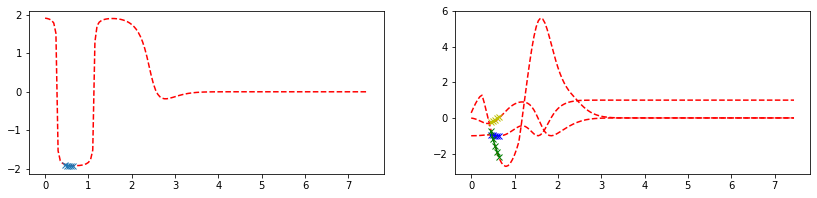

iteration 15 converged 5.151018845876264 [ 2.94959529 -2.37176275] [-1.96047425 -2.0537817 ]
[-0.9816274   0.1908204  -2.37176275] [-0.98389643 -0.1787395  -1.16383981]


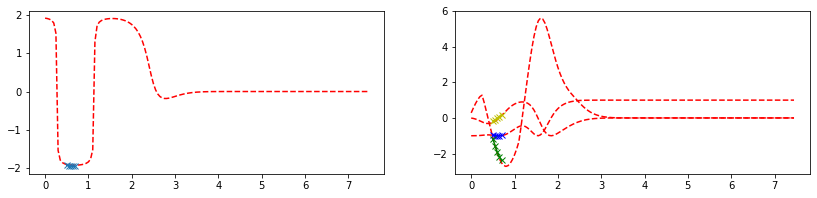

iteration 19 converged 6.529121985875676 [ 2.8275989  -2.48397636] [-2.06382896 -2.15132338]
[-0.95111006  0.30886036 -2.48397636] [-0.99380736 -0.11111676 -1.56220205]


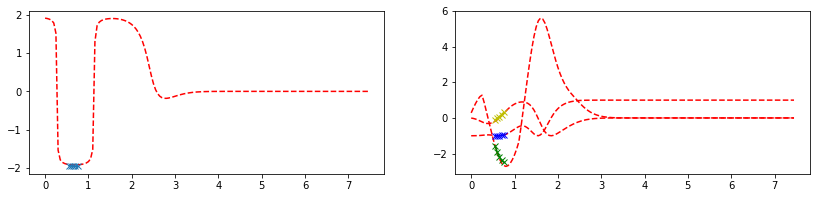

iteration 16 converged 7.735696265490611 [ 2.70239229 -2.50876522] [-2.1367654  -2.21803593]
[-0.90509403  0.42521682 -2.50876522] [-0.99970225 -0.02440093 -1.90489092]


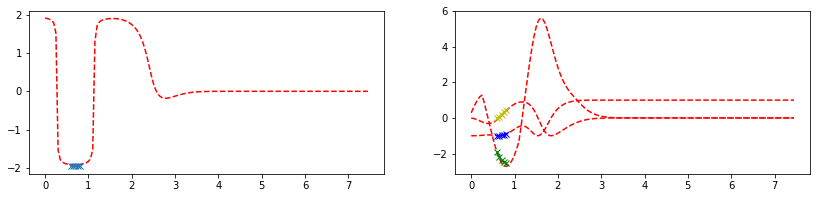

iteration 16 converged 8.573440002665762 [ 2.57818868 -2.44979835] [-2.18464262 -2.26019477]
[-0.84544349  0.53406805 -2.44979835] [-0.99695986  0.0779169  -2.17852415]


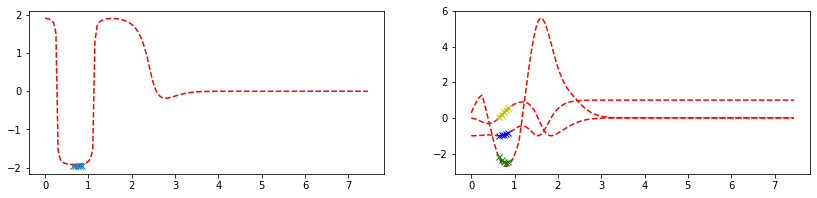

[-0.7759167   0.63083649 -2.31447721] [-0.98159947  0.19095153 -2.37302104]


/Users/fei/Documents/UCL/Thesis/Code/MBRL_HNN/ilqr/controller.py:171: UserWarning: exceeded max regularization term
  warnings.warn("exceeded max regularization term")


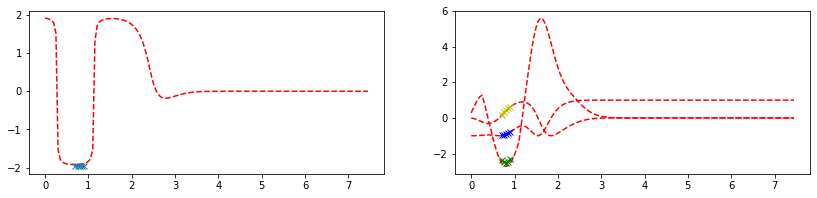

iteration 5 converged 8.70295943115085 [ 2.34828454 -2.11269736] [-2.22559443 -2.28815346]
[-0.7014913   0.71267754 -2.11269736] [-0.95114348  0.30874922 -2.48237273]


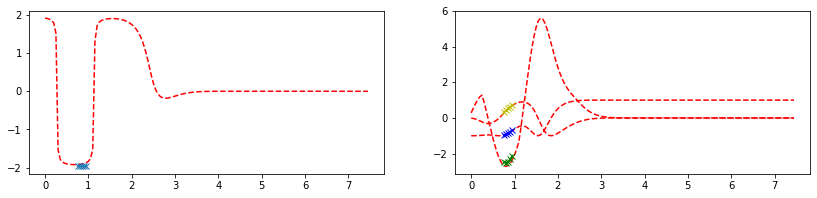

iteration 6 converged 7.941204289025197 [ 2.24923084 -1.85553312] [-2.21748161 -2.27070506]
[-0.62757432  0.77855533 -1.85553312] [-0.90521024  0.42496402 -2.50514064]


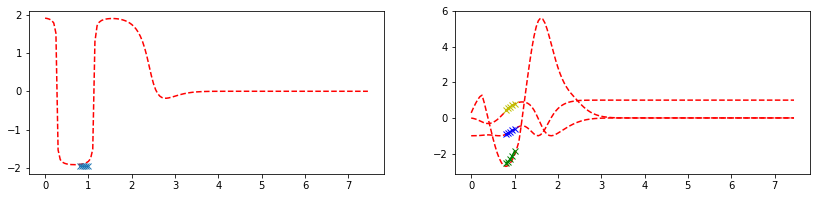

iteration 9 converged 6.594688987918845 [ 2.16438905 -1.5535624 ] [-2.17685511 -2.22314851]
[-0.55934179  0.82893503 -1.5535624 ] [-0.84566304  0.53371718 -2.44423142]


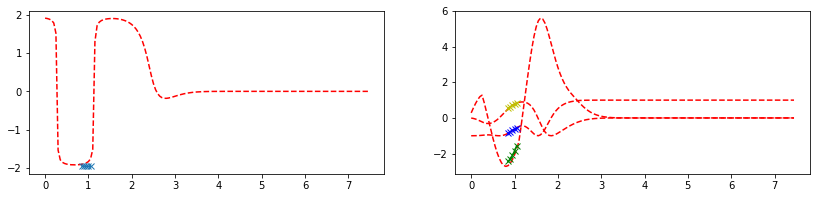

iteration 12 converged 4.299571230213775 [ 2.09653741 -1.21126676] [-2.03735174 -2.07447065]
[-0.50185311  0.86495048 -1.21126676] [-0.77630087  0.63036256 -2.30511487]


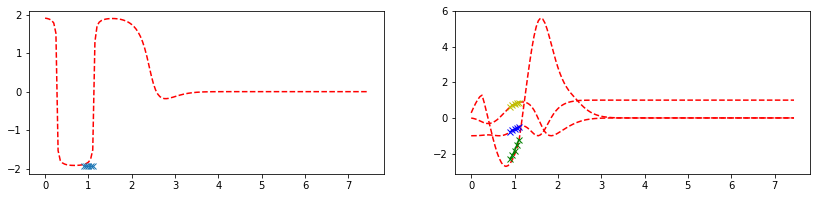

iteration 28 converged 1.0702679246240479 [ 2.08075709 -0.48783424] [-1.17466898 -1.08352732]
[-0.48814172  0.87276137 -0.48783424] [-0.7028844   0.7113041  -2.05822554]


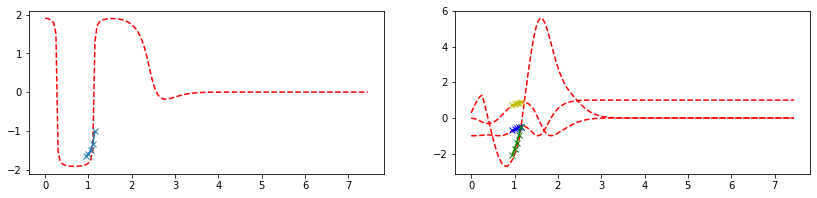

iteration 17 converged 0.8176256242414057 [2.08729907 0.42502713] [-1.07348706 -0.93195473]
[-0.49384087  0.86954939  0.42502713] [-0.63197792  0.77498639 -1.74763747]


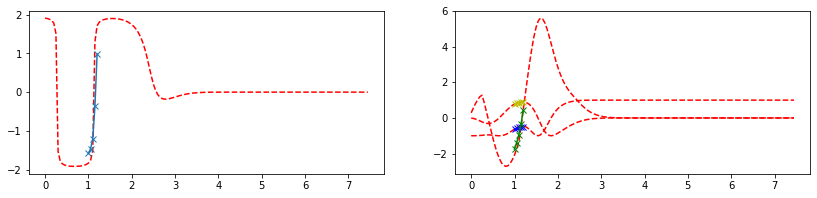

iteration 14 converged 0.7325225192850522 [2.13740256 1.34530115] [-0.94281355 -0.68664197]
[-0.53677064  0.8437258   1.34530115] [-0.56939125  0.82206666 -1.38009795]


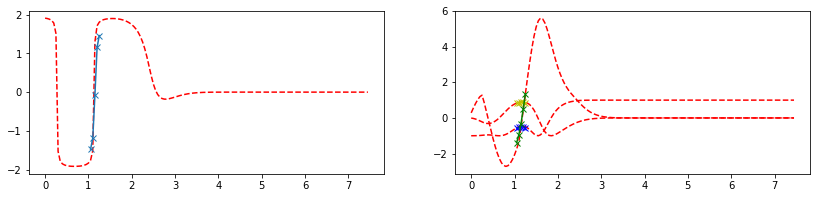

iteration 24 converged 0.8636522976337312 [2.23373426 2.24652672] [-0.69760943  0.06927376]
[-0.61543429  0.78818643  2.24652672] [-0.52062001  0.8537885  -0.94354451]


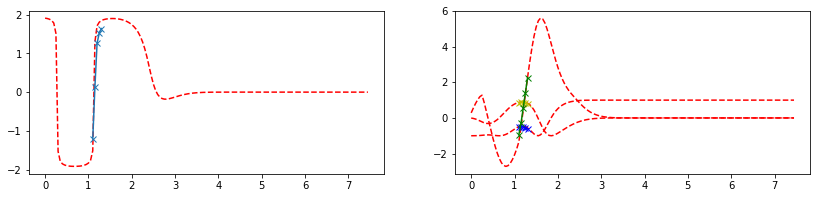

iteration 10 converged 1.2961947017802906 [2.37530639 3.10251689] [0.14443162 0.82691795]
[-0.72049057  0.69346392  3.10251689] [-0.49453675  0.86915672 -0.26558461]


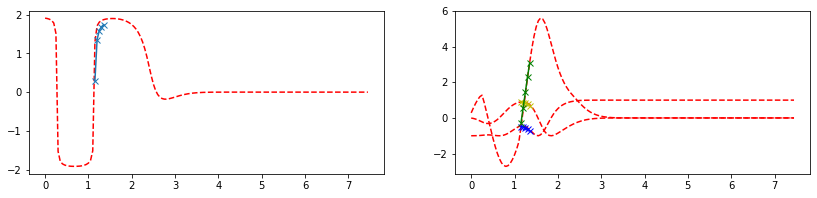

iteration 10 converged 2.099293018927889 [2.55727179 3.87969685] [0.96969017 1.20133872]
[-0.83408737  0.55163336  3.87969685] [-0.5017592   0.86500735  0.59825977]


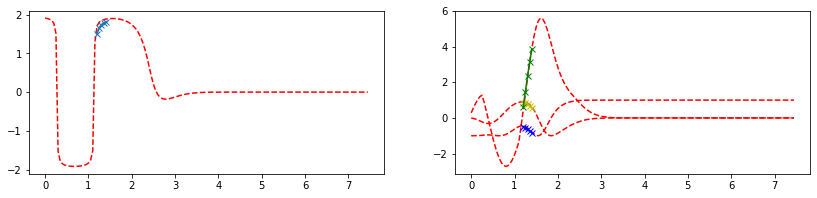

iteration 14 converged 3.1989954847288673 [2.77367512 4.53559399] [1.38421296 1.51737264]
[-0.93307954  0.35967356  4.53559399] [-0.54629978  0.83758972  1.49074226]


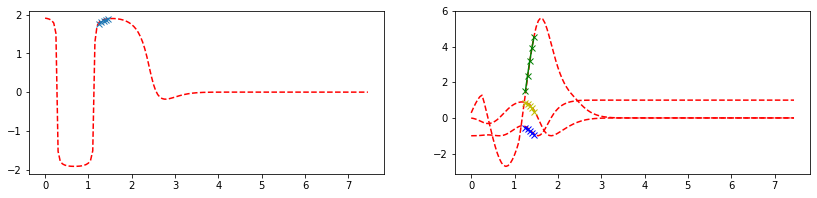

iteration 17 converged 4.67264725690103 [3.01666785 5.02643299] [1.68556286 1.78740354]
[-0.99220836  0.12460029  5.02643299] [-0.62457624  0.78096384  2.36827766]


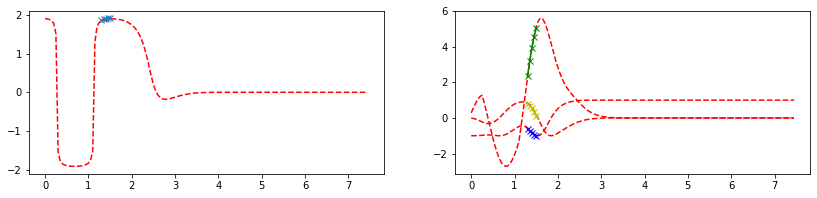

iteration 9 converged 6.518677585074493 [-3.00546841  5.3253665 ] [1.89304185 1.98559013]
[-0.9907499  -0.13570431  5.3253665 ] [-0.72705349  0.68658082  3.19743634]


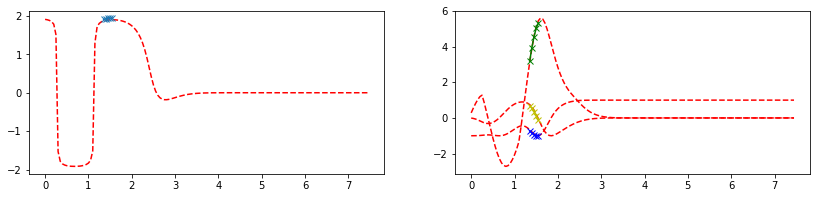

iteration 8 converged 8.501308101724598 [-2.73528114  5.42707539] [2.0328862  2.12017287]
[-0.91858351 -0.39522326  5.42707539] [-0.83765875  0.54619394  3.94383539]


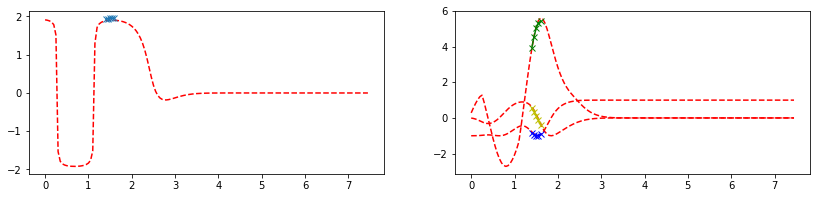

iteration 15 converged 10.199188472903359 [-2.46506521  5.34493542] [2.13057632 2.2124431 ]
[-0.77974808 -0.62608629  5.34493542] [-0.93434728  0.35636381  4.57049363]


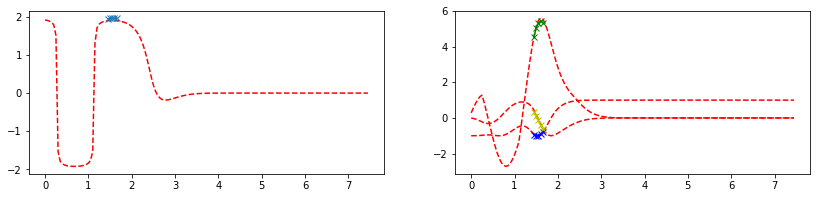

iteration 15 converged 11.229243862176107 [-2.20313286  5.10949326] [2.19792908 2.26916512]
[-0.59102648 -0.80664241  5.10949326] [-0.99240208  0.12303704  5.04180553]


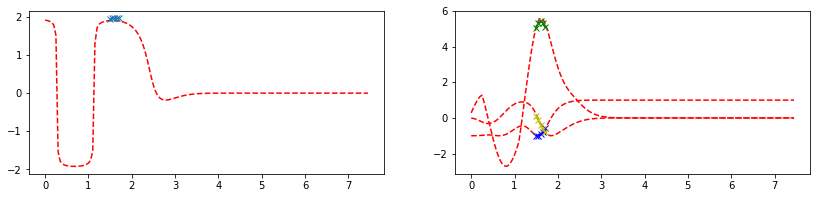

/Users/fei/Documents/UCL/Thesis/Code/MBRL_HNN/ilqr/controller.py:171: UserWarning: exceeded max regularization term
  warnings.warn("exceeded max regularization term")


[-0.37576878 -0.92670178  4.76264811] [-0.99066155 -0.13634406  5.33111796]


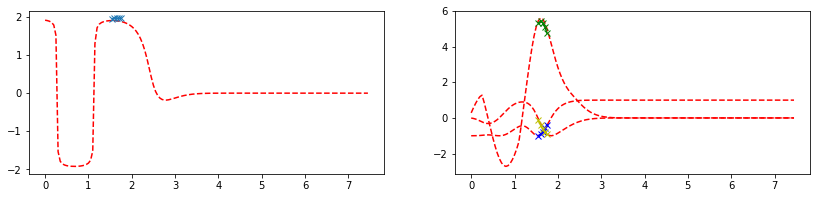

iteration 7 converged 10.912122936059275 [-1.72815678  4.3489995 ] [2.2744828  2.31520261]
[-0.15670989 -0.98763222  4.3489995 ] [-0.91849007 -0.39544404  5.42829727]


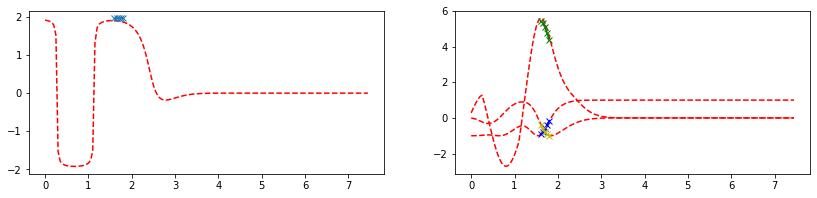

iteration 5 converged 9.892614471273639 [-1.52182836  3.90888071] [2.28591889 2.31127724]
[ 0.04894781 -0.99878937  3.90888071] [-0.77972946 -0.62611658  5.34382905]


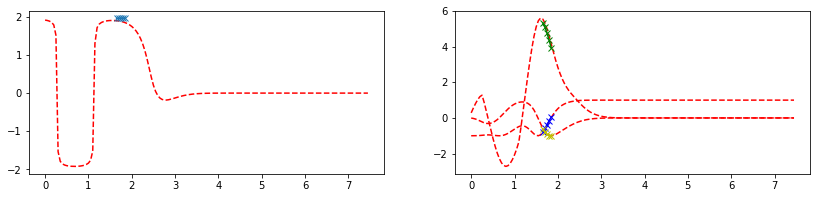

iteration 5 converged 8.626827849721607 [-1.33752874  3.47412062] [2.27957616 2.29461515]
[ 0.23115556 -0.97290665  3.47412062] [-0.5910893  -0.80660612  5.10701593]


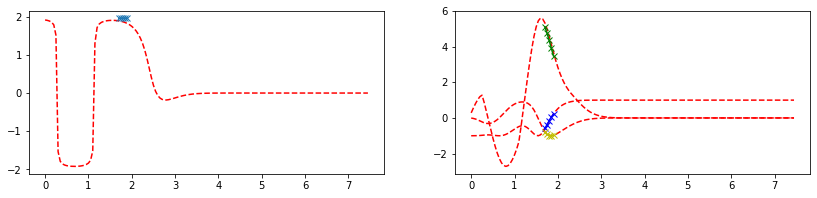

iteration 6 converged 7.303950570234652 [-1.17442843  3.06685758] [2.25916418 2.25181193]
[ 0.38606772 -0.92246294  3.06685758] [-0.37591764 -0.92665308  4.75913902]


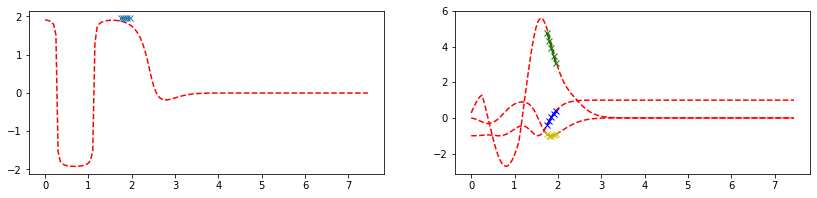

/Users/fei/Documents/UCL/Thesis/Code/MBRL_HNN/ilqr/controller.py:171: UserWarning: exceeded max regularization term
  warnings.warn("exceeded max regularization term")


[ 0.51414448 -0.85769928  2.70076871] [-0.15695808 -0.98760527  4.34448883]


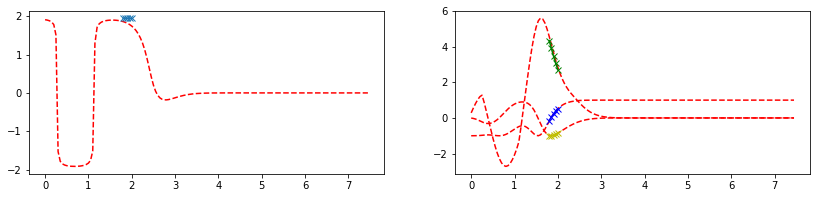

iteration 19 converged 4.876322261292913 [-0.90444823  2.38223839] [2.15162372 2.12919217]
[ 0.61811882 -0.78608346  2.38223839] [ 0.04859333 -0.99881865  3.90305368]


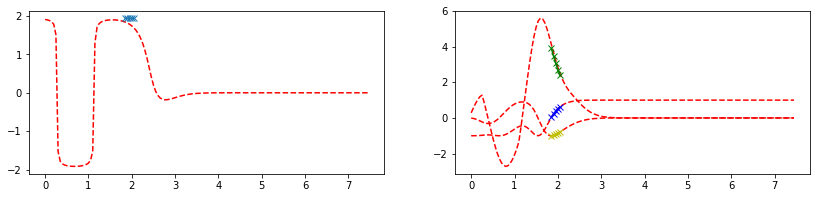

iteration 13 converged 3.8556277928743463 [-0.79315907  2.11205268] [2.05765904 2.02568037]
[ 0.70159835 -0.71257383  2.11205268] [ 0.2306669  -0.97303278  3.46615582]


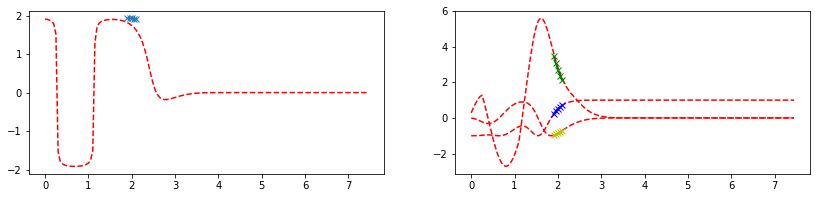

iteration 45 converged 2.997484438566395 [-0.69487597  1.88587666] [1.92570614 1.88540498]
[ 0.76813459 -0.64029139  1.88587666] [ 0.38539869 -0.92275016  3.05510459]


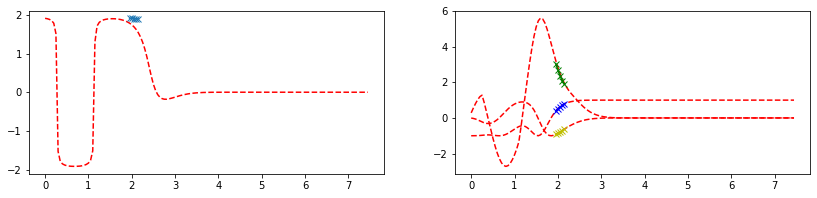

iteration 30 converged 2.3236064741230242 [-0.60802624  1.69482708] [1.75643889 1.71019812]
[ 0.82077897 -0.57124984  1.69482708] [ 0.51316448 -0.85829029  2.68192899]


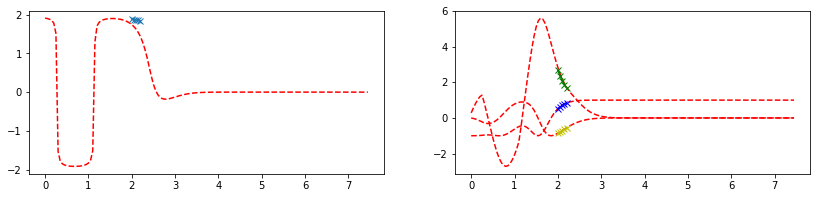

iteration 11 converged 1.8282676274702618 [-0.53116372  1.5290395 ] [1.58580915 1.52251559]
[ 0.86222005 -0.50653815  1.5290395 ] [ 0.61666805 -0.7872233   2.35221187]


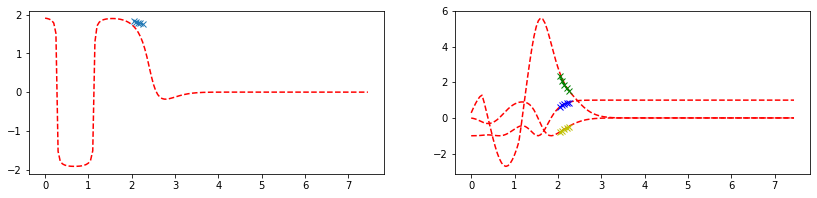

iteration 12 converged 1.470605222918567 [-0.46263284  1.38094187] [1.42894839 1.35261736]
[ 0.89488226 -0.44630659  1.38094187] [ 0.69954832 -0.7145853   2.06718486]


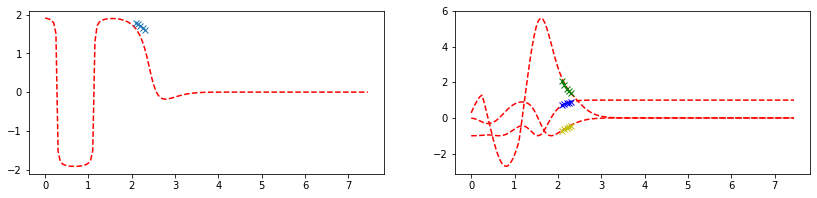

iteration 11 converged 1.206441109161496 [-0.40052527  1.24358749] [1.30603339 1.20943689]
[ 0.92085785 -0.38990274  1.24358749] [ 0.76554969 -0.64337677  1.82675245]


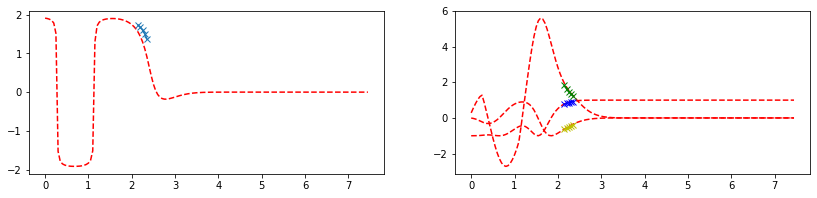

iteration 78 converged 0.9944135695929114 [-0.34278075  1.11017168] [1.2158645  1.08900955]
[ 0.94182503 -0.33610785  1.11017168] [ 0.81810663 -0.57506656  1.63024609]


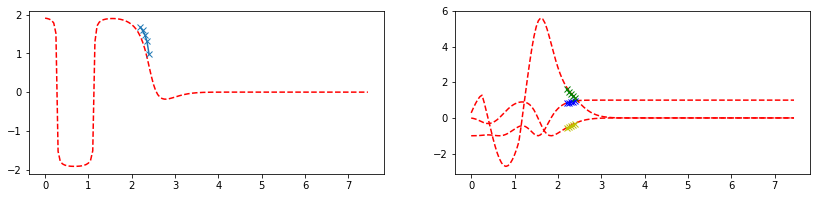

iteration 21 converged 0.8002378869780246 [-0.28806987  0.9771201 ] [1.11451533 0.99036058]
[ 0.95879525 -0.28410253  0.9771201 ] [ 0.86011311 -0.51010336  1.4729405 ]


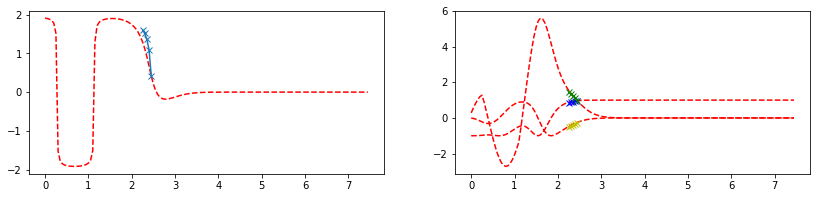

iteration 13 converged 0.6148072309750237 [-0.23713392  0.84584928] [1.00606689 0.86701415]
[ 0.97201633 -0.23491798  0.84584928] [ 0.89385457 -0.44835701  1.34977158]


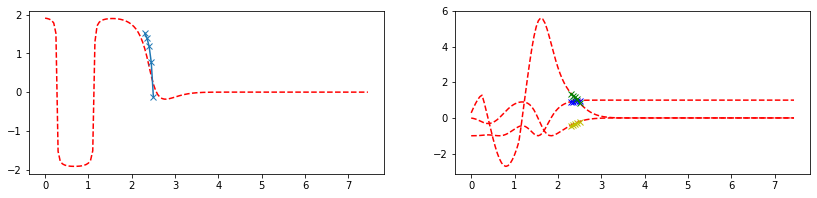

iteration 29 converged 0.44360386598072005 [-0.19144651  0.72044665] [0.86530408 0.71277618]
[ 0.981731   -0.19027936  0.72044665] [ 0.92103089 -0.38948954  1.25140847]


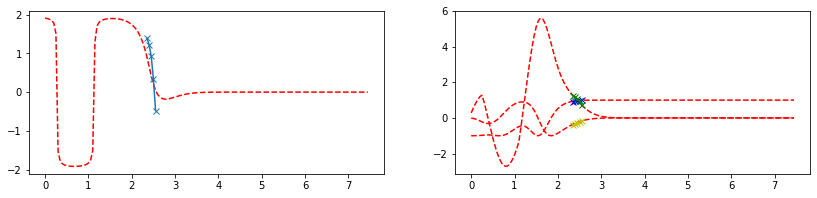

iteration 10 converged 0.2998673553614968 [-0.15161247  0.60461235] [0.70034451 0.52211006]
[ 0.98852986 -0.15103246  0.60461235] [ 0.94282535 -0.3332872   1.16705332]


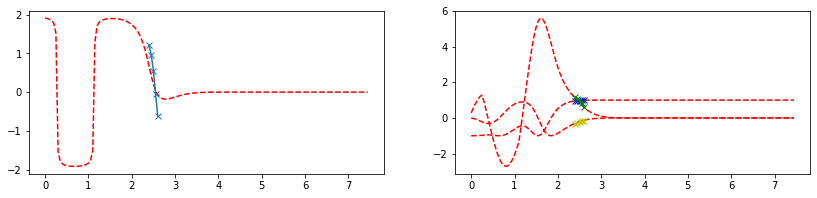

iteration 4 converged 0.19069460186098383 [-0.11784698  0.50063777] [0.50089504 0.31347165]
[ 0.993065   -0.11757451  0.50063777] [ 0.96000878 -0.27996989  1.080491  ]


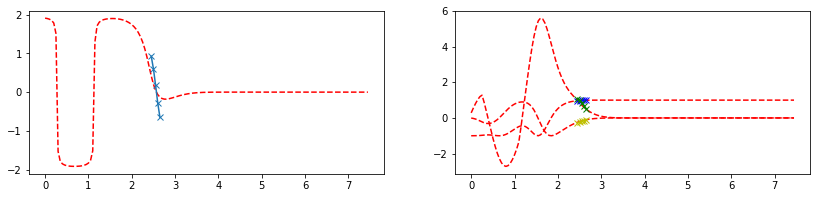

iteration 3 converged 0.11798766136118287 [-0.09004373  0.40942734] [0.28854311 0.12211268]
[ 0.99594969 -0.08992218  0.40942734] [ 0.97310004 -0.23038297  0.97724763]


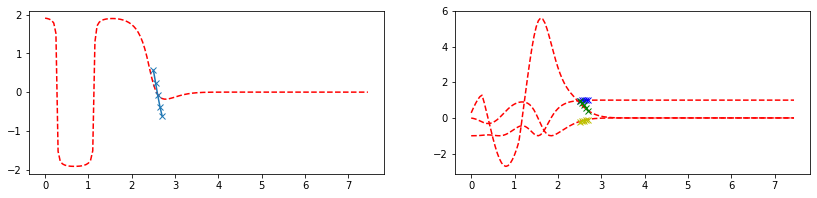

iteration 2 converged 0.07488065947381468 [-0.06765314  0.3308928 ] [ 0.1005633  -0.01283047]
[ 0.99771315 -0.0676016   0.3308928 ] [ 0.98260126 -0.18572768  0.85457964]


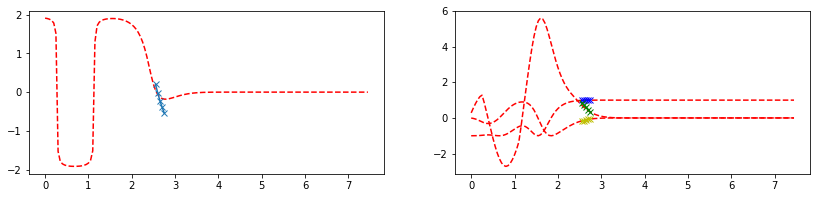

iteration 2 converged 0.0501426874145718 [-0.04996491  0.26432851] [-0.02900265 -0.08999924]
[ 0.99875265 -0.04994416  0.26432851] [ 0.98914604 -0.14693577  0.7238818 ]


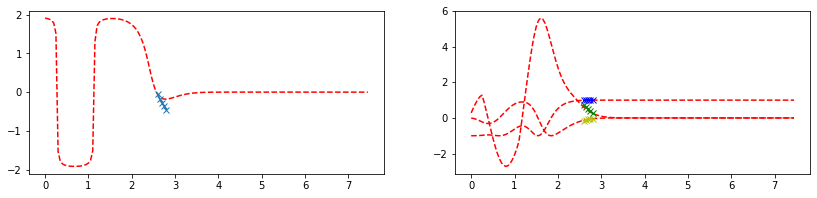

iteration 2 converged 0.034755947862214906 [-0.03622273  0.20868489] [-0.10149638 -0.12699075]
[ 0.99934447 -0.03621482  0.20868489] [ 0.99344892 -0.11427708  0.59781759]


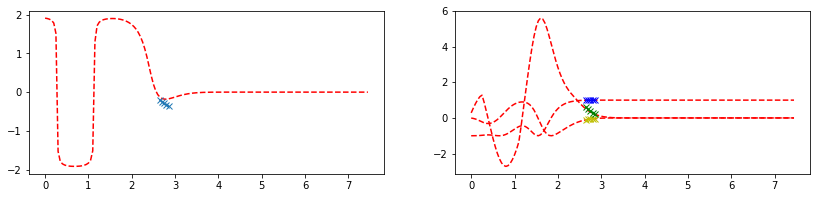

iteration 2 converged 0.024277368093680585 [-0.02571136  0.16275683] [-0.13484504 -0.13904256]
[ 0.99966973 -0.02570853  0.16275683] [ 0.99616815 -0.0874587   0.4837372 ]


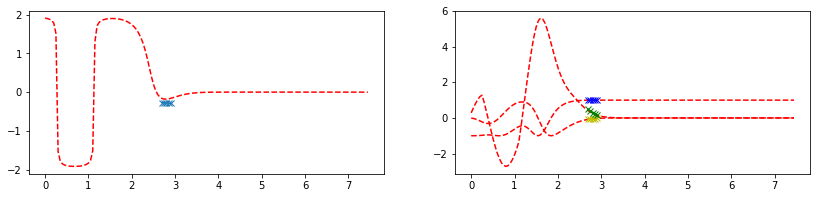

iteration 2 converged 0.01681911479826035 [-0.01778724  0.12530179] [-0.14413921 -0.13631254]
[ 0.99984193 -0.0177863   0.12530179] [ 0.99782766 -0.06587843  0.38468392]


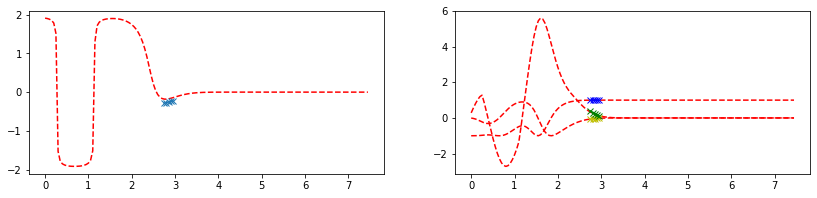

iteration 2 converged 0.011467994731220517 [-0.01189875  0.0951132 ] [-0.13939964 -0.12541668]
[ 0.99992931 -0.01189847  0.0951132 ] [ 0.99880798 -0.04881208  0.3011954 ]


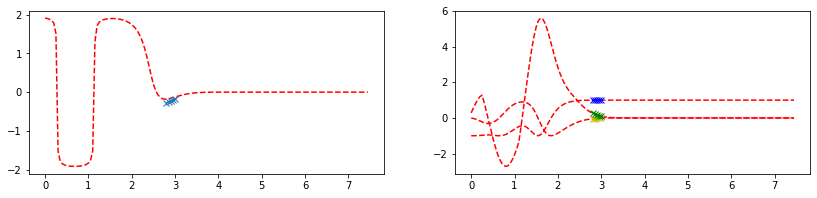

iteration 2 converged 0.007673148451914558 [-0.00758882  0.07106512] [-0.12711556 -0.11066976]
[ 0.99997127 -0.00758875  0.07106512] [ 0.99936884 -0.03552359  0.23244981]


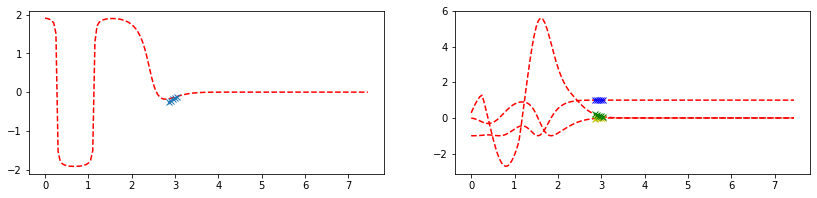

iteration 2 converged 0.005037433360394481 [-0.00448753  0.05213605] [-0.11147229 -0.09481905]
[ 0.99999005 -0.00448752  0.05213605] [ 0.99967927 -0.02532508  0.17693108]


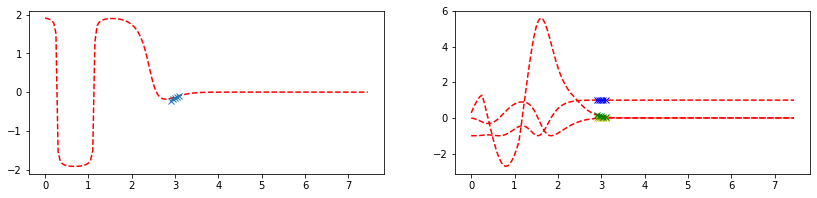

iteration 2 converged 0.0032498016549740672 [-0.00230088  0.03742076] [-0.09508919 -0.0795058 ]
[ 0.99999738 -0.00230088  0.03742076] [ 0.99984499 -0.01760647  0.13283155]


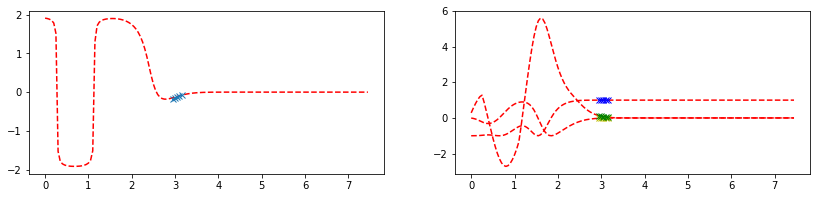

iteration 2 converged 0.0020650486481003584 [-0.00079847  0.02613183] [-0.07949303 -0.06560284]
[ 0.99999964 -0.00079847  0.02613183] [ 0.99992983 -0.01184634  0.09830454]


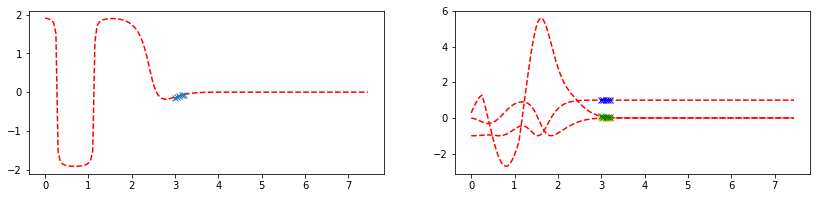

iteration 2 converged 0.0012958244833422947 [0.00020087 0.0175965 ] [-0.06542915 -0.05345891]
[0.99999994 0.00020087 0.0175965 ] [ 0.99997103 -0.00761122  0.07162752]


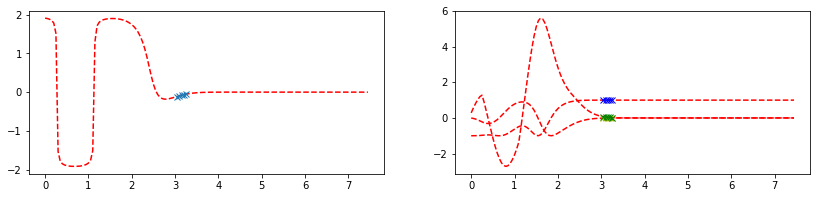

iteration 1 converged 0.0008053723607435586 [0.00082825 0.01124769] [-0.05330759 -0.0431837 ]
[0.99999958 0.00082825 0.01124769] [ 0.99998965 -0.00454899  0.0512394 ]


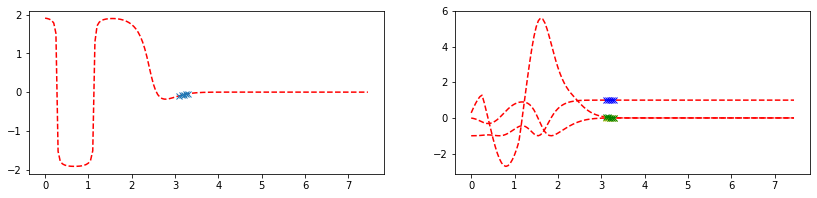

iteration 1 converged 0.0004963051090168386 [0.00119082 0.00661414] [-0.04303826 -0.03460667]
[0.99999923 0.00119082 0.00661414] [ 0.99999717 -0.00237881  0.03583452]


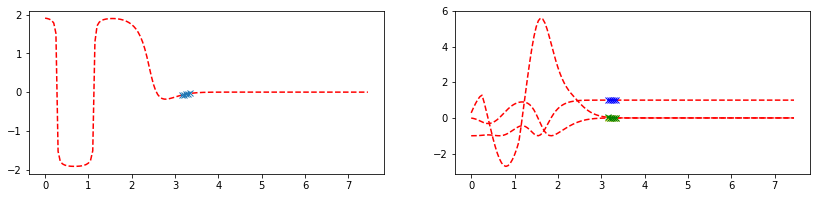

iteration 1 converged 0.0003036896840911822 [0.00136714 0.00330953] [-0.03448613 -0.02753928]
[0.99999905 0.00136714 0.00330953] [ 0.99999961 -0.0008793   0.02432945]


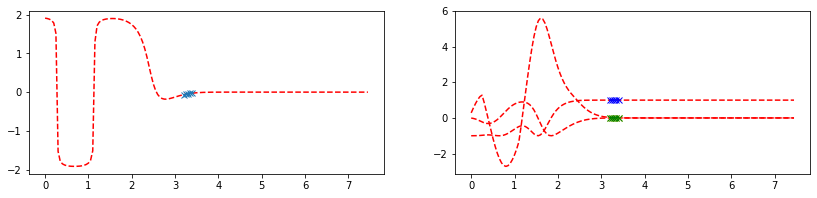

iteration 1 converged 0.0001846971632132532 [0.00141582 0.00102086] [-0.02744837 -0.02176939]
[0.99999899 0.00141582 0.00102086] [0.99999999 0.00012198 0.0158444 ]


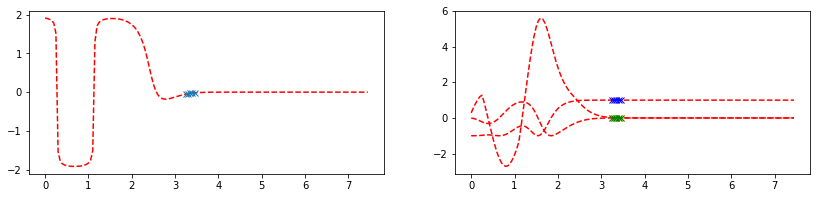

iteration 1 converged 0.00011169926621279103 [ 0.0013802 -0.0005029] [-0.02170492 -0.01708967]
[ 0.99999905  0.0013802  -0.0005029 ] [0.99999971 0.00075805 0.00967659]


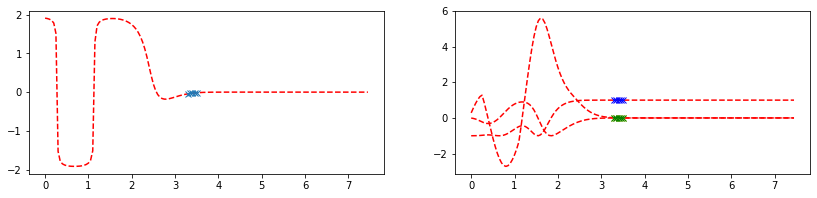

iteration 1 converged 6.718963446933388e-05 [ 0.00129193 -0.00146017] [-0.01704567 -0.01331435]
[ 0.99999911  0.00129193 -0.00146017] [0.99999936 0.00113062 0.00527167]


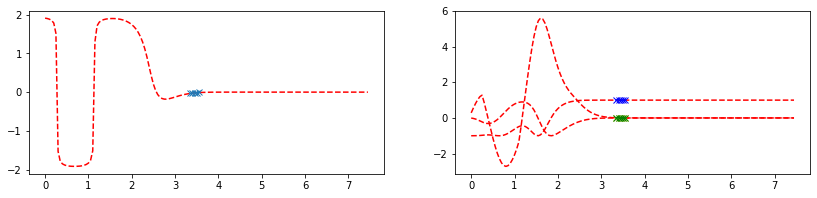

iteration 1 converged 4.0204791556394015e-05 [ 0.00117381 -0.00200637] [-0.01328411 -0.01028272]
[ 0.99999934  0.00117381 -0.00200637] [0.99999913 0.00131675 0.00219642]


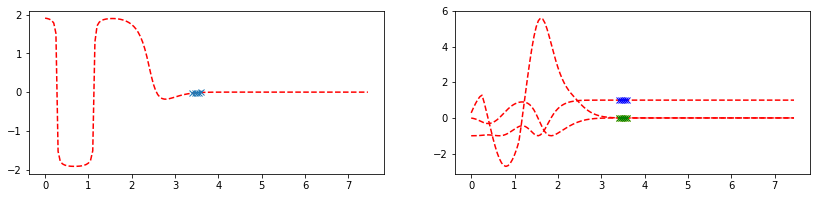

iteration 1 converged 2.3939782531700597e-05 [ 0.00104188 -0.00226141] [-0.01026108 -0.00786007]
[ 0.99999946  0.00104188 -0.00226141] [0.99999906 0.00137435 0.00011457]


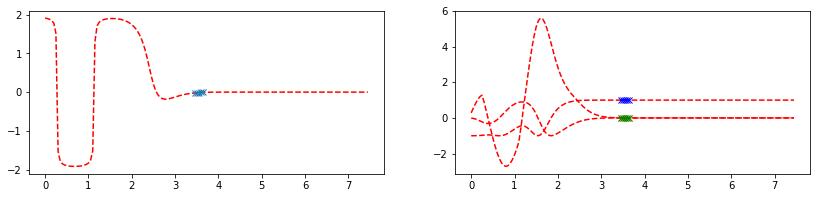

iteration 1 converged 1.4199781387613189e-05 [ 0.00090721 -0.00231641] [-0.0078433  -0.00593515]
[ 0.99999958  0.00090721 -0.00231641] [ 0.99999909  0.00134646 -0.00123333]


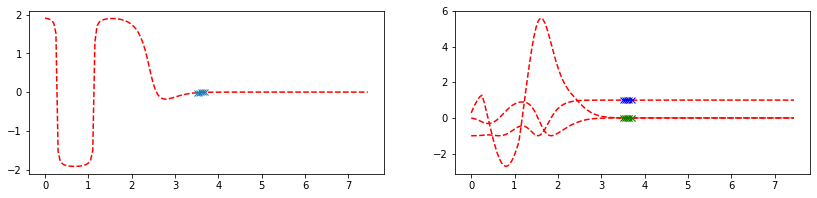

iteration 1 converged 8.405266353900383e-06 [ 0.00077704 -0.00223998] [-0.00592079 -0.00441569]
[ 0.9999997   0.00077704 -0.00223998] [ 0.9999992   0.00126472 -0.00204646]


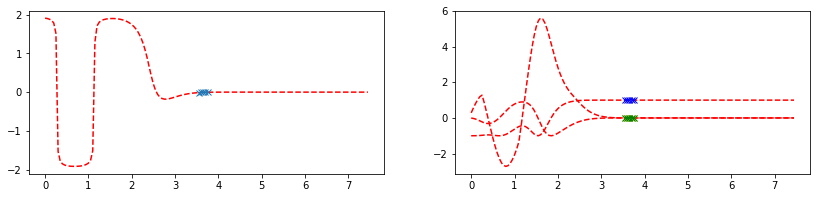

iteration 1 converged 4.9806894285507796e-06 [ 0.0006559  -0.00208265] [-0.00440242 -0.00322589]
[ 0.99999976  0.0006559  -0.00208265] [ 0.99999934  0.00115198 -0.00247682]


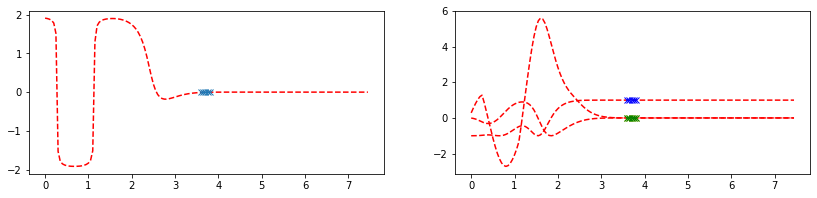

iteration 1 converged 2.96864888450069e-06 [ 0.0005463 -0.0018807] [-0.00321295 -0.0023029 ]
[ 0.99999982  0.0005463  -0.0018807 ] [ 0.99999948  0.00102446 -0.00263954]


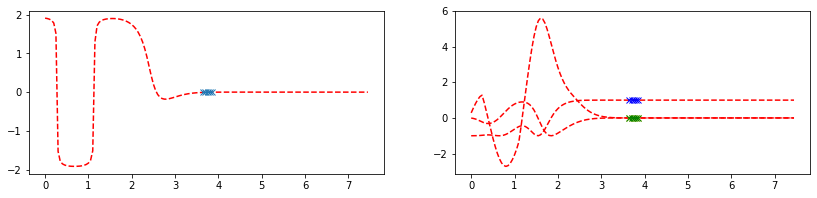

iteration 1 converged 1.7916016256737522e-06 [ 0.00044939 -0.00165962] [-0.00229001 -0.00159517]
[ 0.99999988  0.00044939 -0.00165962] [ 0.9999996   0.00089335 -0.00262108]


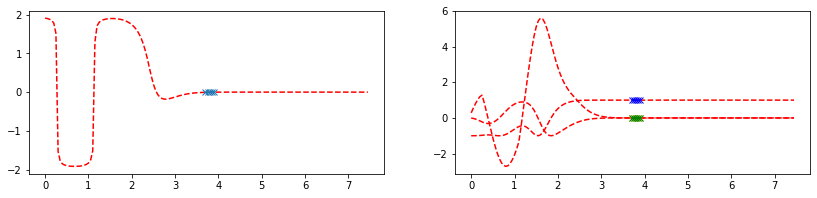

iteration 1 converged 1.1035650655925153e-06 [ 0.00036525 -0.00143707] [-0.00158275 -0.00105998]
[ 0.99999994  0.00036525 -0.00143707] [ 0.99999971  0.00076607 -0.00248586]


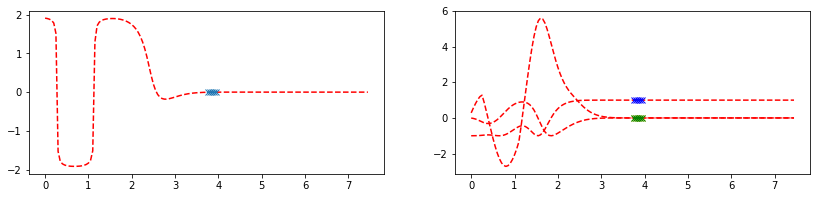

iteration 1 converged 6.990768512851064e-07 [ 0.00029339 -0.00122432] [-0.0010482  -0.00066184]
[ 0.99999994  0.00029339 -0.00122432] [ 0.99999979  0.00064726 -0.00228103]


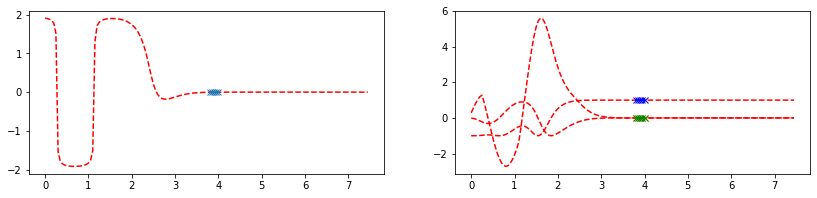

iteration 1 converged 4.5827711064346504e-07 [ 0.00023291 -0.00102804] [-0.00065088 -0.00037153]
[ 0.99999994  0.00023291 -0.00102804] [ 0.99999985  0.00053955 -0.00204043]


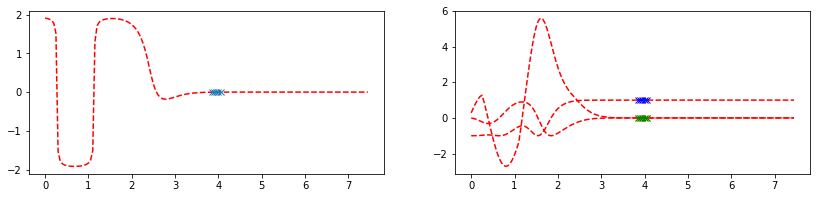

iteration 1 converged 3.118811887812626e-07 [ 0.00018267 -0.00085198] [-0.00036156 -0.00016513]
[ 1.          0.00018267 -0.00085198] [ 0.9999999   0.00044414 -0.00178779]


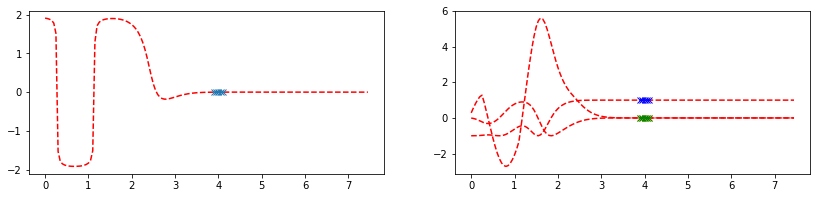

iteration 0 converged 2.1975794019646945e-07 [ 0.0001418 -0.0006978] [-0.00015206 -0.00002095]
[ 0.99999994  0.0001418  -0.0006978 ] [ 0.99999993  0.00036125 -0.00153789]


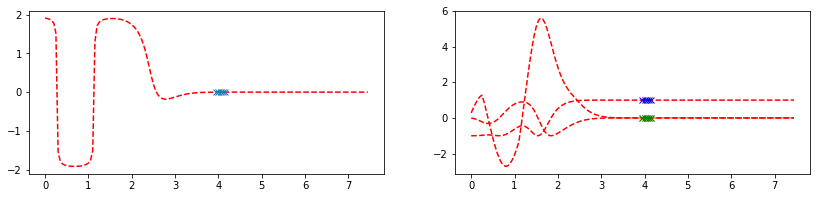

iteration 0 converged 1.6002942793314253e-07 [ 0.00010842 -0.00056443] [-0.00001478  0.00007023]
[ 0.99999994  0.00010842 -0.00056443] [ 0.99999996  0.00029044 -0.00130331]


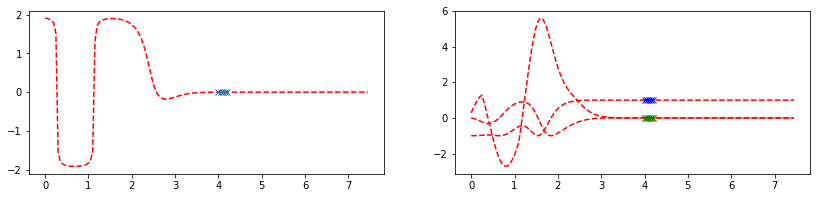

iteration 0 converged 1.196319749129883e-07 [ 0.00008165 -0.00045125] [0.00007529 0.00012612]
[ 0.99999994  0.00008165 -0.00045125] [ 0.99999997  0.0002308  -0.00108963]


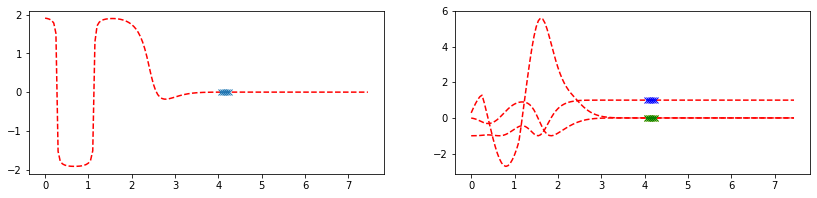

iteration 0 converged 9.169747424218709e-08 [ 0.00006045 -0.0003565 ] [0.00013022 0.00015643]
[ 1.          0.00006045 -0.0003565 ] [ 0.99999998  0.00018122 -0.00089957]


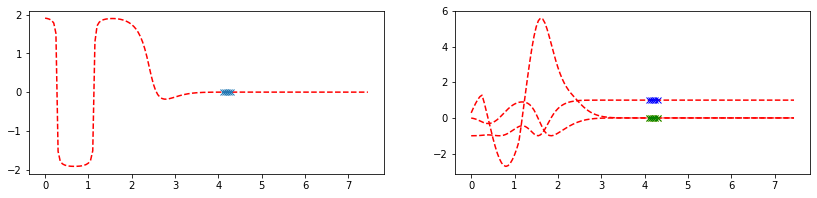

iteration 0 converged 7.174079480865026e-08 [ 0.00004388 -0.00027824] [0.00016009 0.00016888]
[ 1.          0.00004388 -0.00027824] [ 0.99999999  0.00014051 -0.00073369]


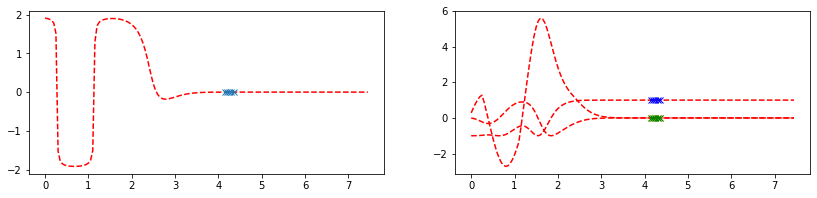

iteration 0 converged 5.738963795572707e-08 [ 0.00003108 -0.00021448] [0.00017187 0.00016877]
[ 1.          0.00003108 -0.00021448] [ 0.99999999  0.00010749 -0.00059134]


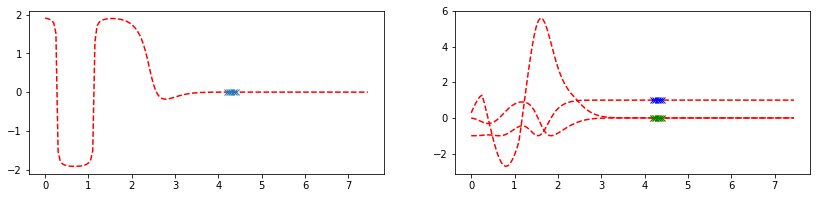

iteration 0 converged 4.7060594260724685e-08 [ 0.00002132 -0.00016298] [0.00017101 0.00016066]
[ 1.          0.00002132 -0.00016298] [ 1.          0.00008101 -0.00047106]


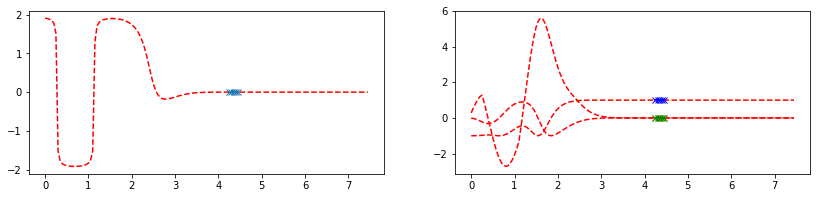

iteration 0 converged 3.962160324140455e-08 [ 0.00001401 -0.00012194] [0.00016234 0.00014767]
[ 1.          0.00001401 -0.00012194] [ 1.          0.00006003 -0.00037078]


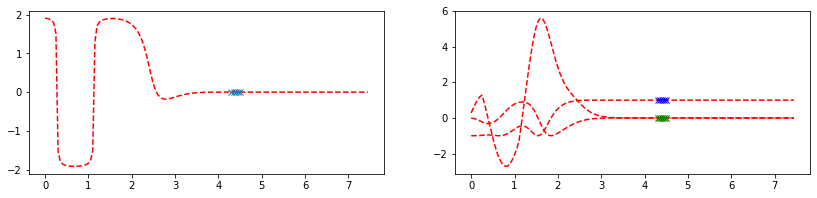

iteration 0 converged 3.4325251146579537e-08 [ 0.00000862 -0.00008953] [0.00014897 0.00013219]
[ 1.          0.00000862 -0.00008953] [ 1.          0.0000436  -0.00028822]


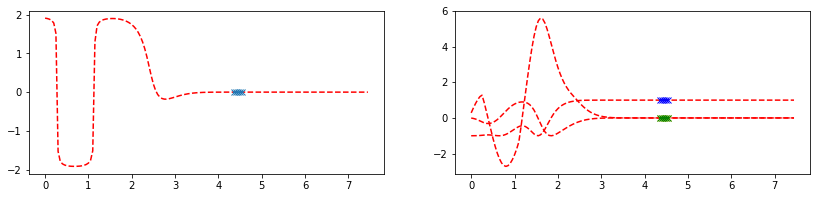

iteration 0 converged 3.059133359985279e-08 [ 0.00000471 -0.00006438] [0.00013297 0.00011552]
[ 1.          0.00000471 -0.00006438] [ 1.          0.00003091 -0.00022113]


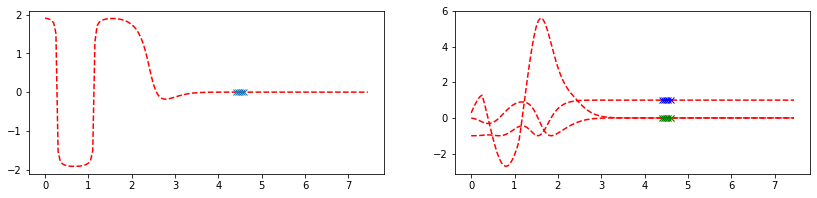

iteration 0 converged 2.8003958871196293e-08 [ 0.00000198 -0.00004511] [0.00011642 0.00009957]
[ 1.          0.00000198 -0.00004511] [ 1.          0.00002123 -0.00016719]


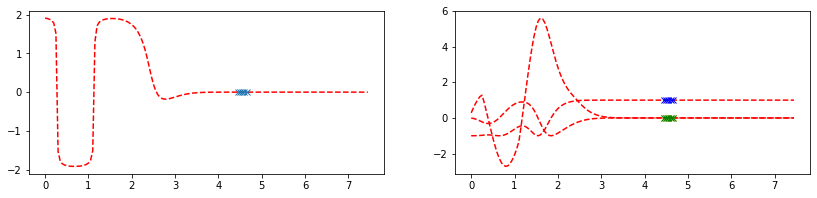

iteration 0 converged 2.6220430594818866e-08 [ 0.00000011 -0.00003053] [0.00010021 0.0000844 ]
[ 1.          0.00000011 -0.00003053] [ 1.          0.00001396 -0.00012431]


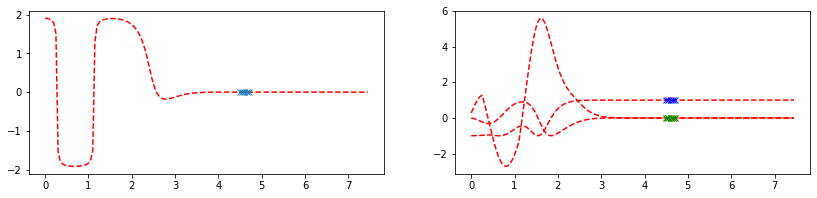

iteration 0 converged 2.5009815672597345e-08 [-0.00000109 -0.00001959] [0.00008481 0.0000705 ]
[ 1.         -0.00000109 -0.00001959] [ 1.          0.00000861 -0.00009066]


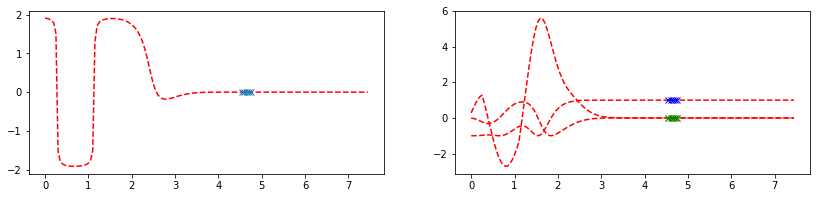

iteration 0 converged 2.4205428776436508e-08 [-0.00000182 -0.00001167] [0.00007077 0.0000581 ]
[ 1.         -0.00000182 -0.00001167] [ 1.          0.00000474 -0.00006461]


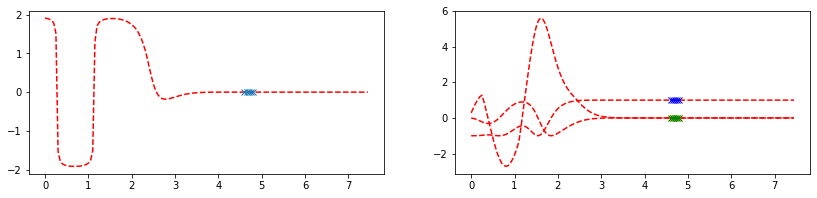

iteration 0 converged 2.367424350171525e-08 [-0.0000022  -0.00000596] [0.00005838 0.00004736]
[ 1.         -0.0000022  -0.00000596] [ 1.          0.00000201 -0.00004467]


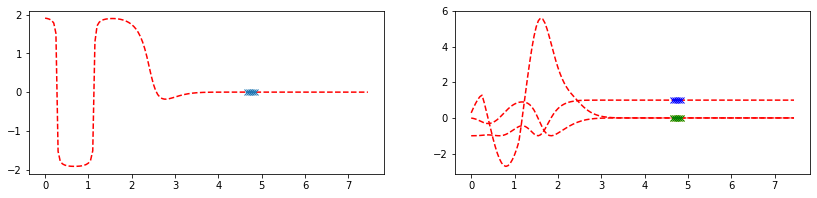

iteration 0 converged 2.3327865644379734e-08 [-0.00000234 -0.00000198] [0.0000475  0.00003809]
[ 1.         -0.00000234 -0.00000198] [ 1.          0.00000016 -0.00002967]


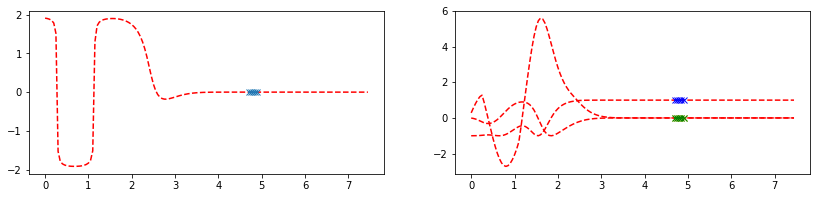

iteration 0 converged 2.3107373246107126e-08 [-0.0000023   0.00000069] [0.00003805 0.00003023]
[ 1.         -0.0000023   0.00000069] [ 1.         -0.00000104 -0.00001861]


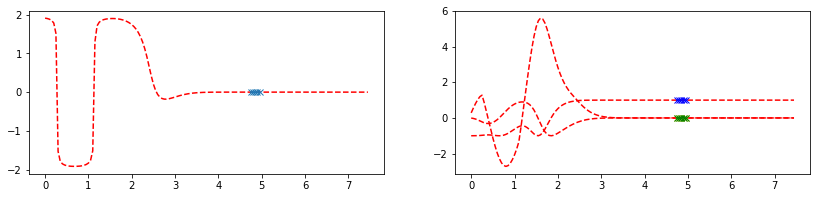

iteration 0 converged 2.297089027729228e-08 [-0.00000218  0.00000243] [0.0000303  0.00002377]
[ 1.         -0.00000218  0.00000243] [ 1.         -0.00000177 -0.00001058]


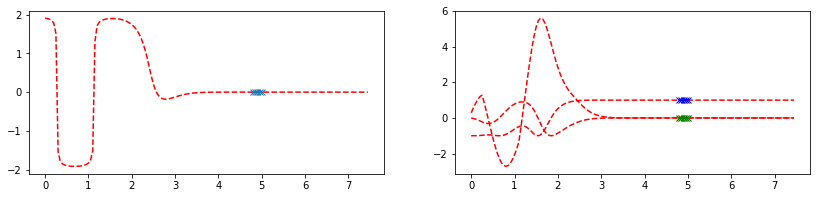

iteration 0 converged 2.288643008571978e-08 [-0.000002    0.00000324] [0.00002393 0.00001836]
[ 1.         -0.000002    0.00000324] [ 1.         -0.00000216 -0.00000487]


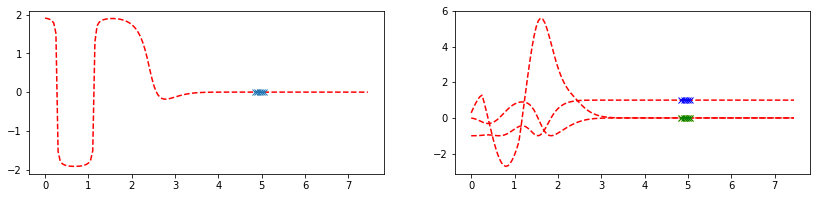

iteration 0 converged 2.2834705266572006e-08 [-0.00000179  0.0000037 ] [0.00001849 0.00001409]
[ 1.         -0.00000179  0.0000037 ] [ 1.         -0.0000023  -0.00000097]


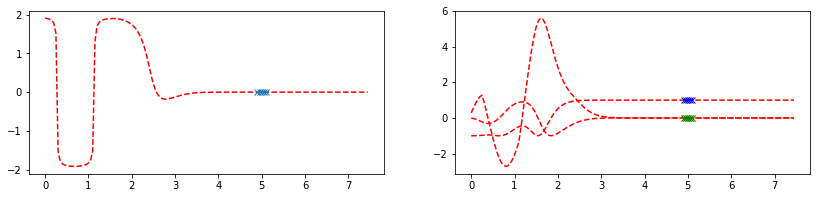

iteration 0 converged 2.2803970449674476e-08 [-0.00000157  0.00000379] [0.00001434 0.00001074]
[ 1.         -0.00000157  0.00000379] [ 1.         -0.00000229  0.00000163]


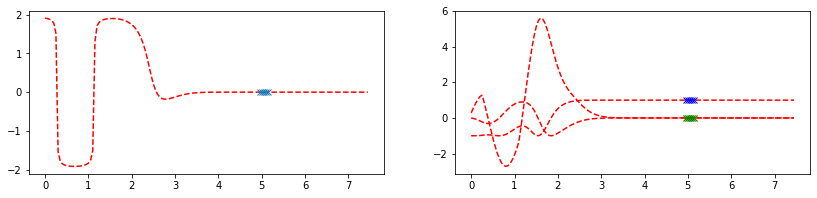

iteration 0 converged 2.27843086749843e-08 [-0.00000135  0.00000372] [0.00001055 0.00000779]
[ 1.         -0.00000135  0.00000372] [ 1.         -0.00000217  0.00000315]


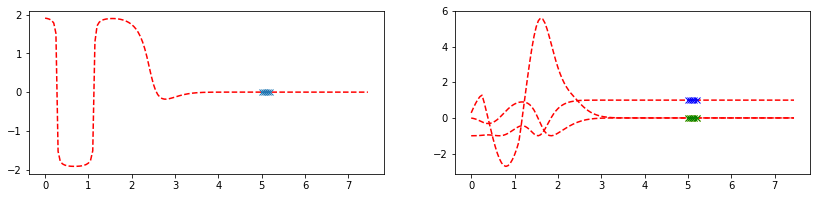

iteration 0 converged 2.2774102646034244e-08 [-0.00000115  0.00000352] [0.00000799 0.00000577]
[ 1.         -0.00000115  0.00000352] [ 1.         -0.00000199  0.00000402]


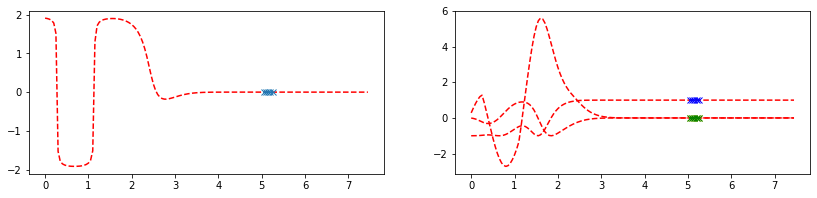

iteration 0 converged 2.2767533464348546e-08 [-0.00000096  0.00000315] [0.00000573 0.00000403]
[ 1.         -0.00000096  0.00000315] [ 1.         -0.00000178  0.00000435]


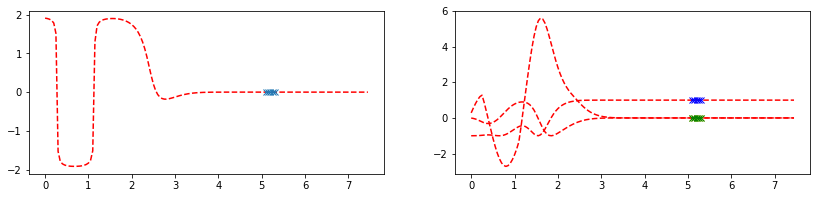

iteration 0 converged 2.2763989523867846e-08 [-0.0000008   0.00000277] [0.00000413 0.00000281]
[ 1.         -0.0000008   0.00000277] [ 1.         -0.00000156  0.00000436]


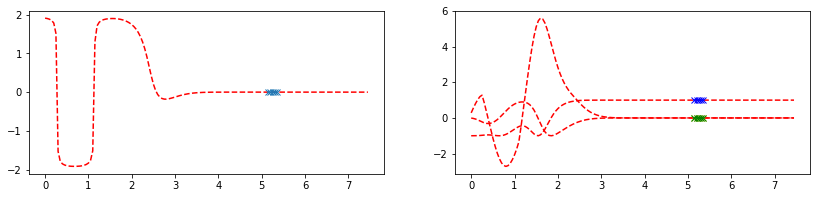

iteration 0 converged 2.276192959067374e-08 [-0.00000066  0.00000238] [0.00000292 0.00000187]
[ 1.         -0.00000066  0.00000238] [ 1.         -0.00000135  0.00000417]


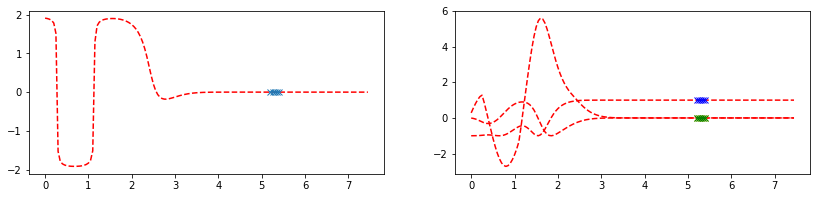

iteration 0 converged 2.276066342764223e-08 [-0.00000054  0.00000207] [0.00000195 0.00000117]
[ 1.         -0.00000054  0.00000207] [ 1.         -0.00000115  0.00000383]


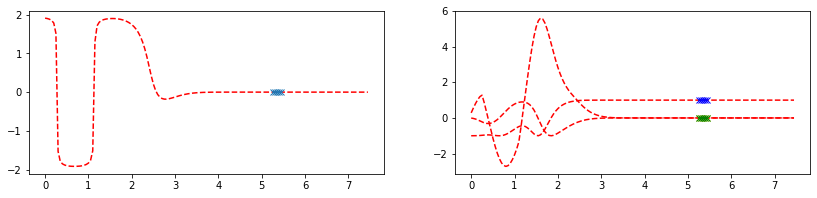

iteration 0 converged 2.2759979710607065e-08 [-0.00000044  0.00000173] [0.00000132 0.00000069]
[ 1.         -0.00000044  0.00000173] [ 1.         -0.00000097  0.00000345]


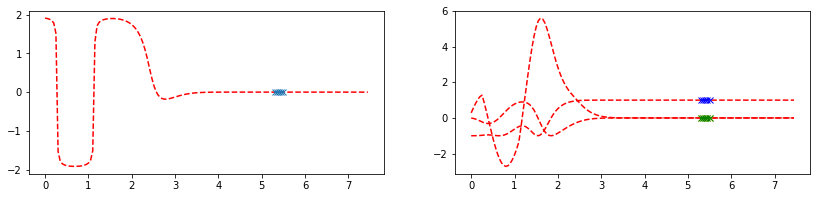

iteration 0 converged 2.2759466130369807e-08 [-0.00000035  0.00000145] [0.00000075 0.00000031]
[ 1.         -0.00000035  0.00000145] [ 1.         -0.00000081  0.00000302]


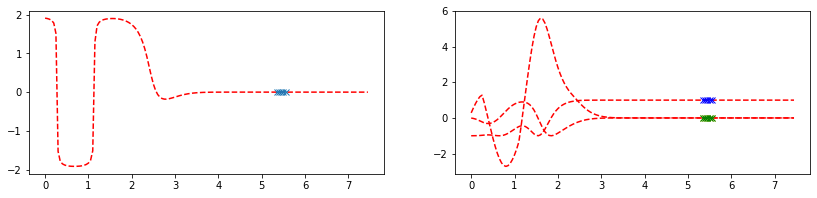

iteration 0 converged 2.2759188771558235e-08 [-0.00000028  0.00000122] [0.00000036 0.00000004]
[ 1.         -0.00000028  0.00000122] [ 1.         -0.00000067  0.00000259]


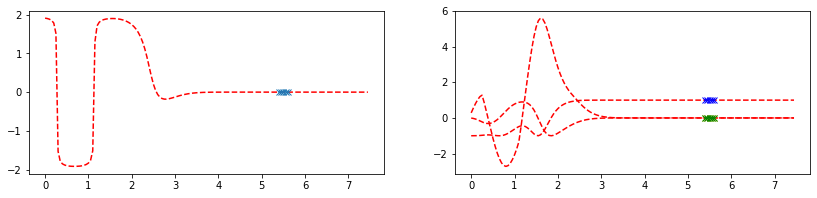

iteration 0 converged 2.2759039795976837e-08 [-0.00000022  0.00000097] [ 0.0000002  -0.00000007]
[ 1.         -0.00000022  0.00000097] [ 1.         -0.00000055  0.00000221]


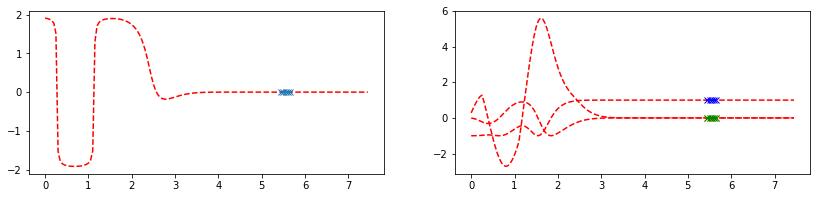

iteration 0 converged 2.2758916056191555e-08 [-0.00000018  0.00000073] [ 0.00000004 -0.00000019]
[ 1.         -0.00000018  0.00000073] [ 1.         -0.00000045  0.00000185]


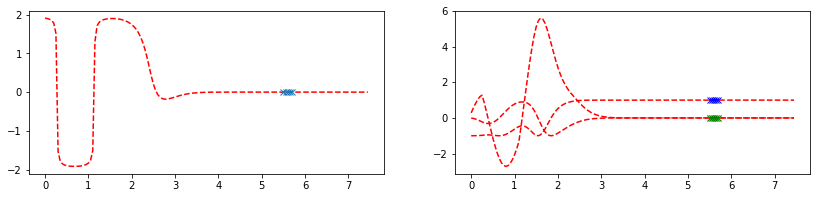

iteration 0 converged 2.2758818953385696e-08 [-0.00000015  0.00000049] [-0.00000005 -0.00000025]
[ 1.         -0.00000015  0.00000049] [ 1.         -0.00000036  0.00000154]


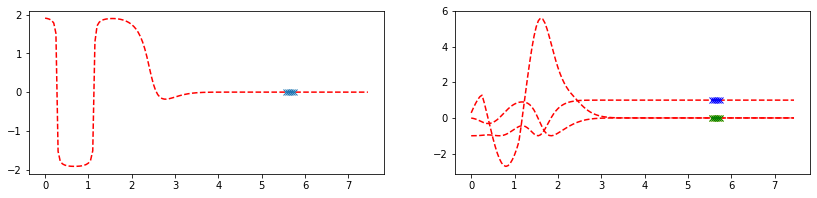

iteration 0 converged 2.275871932880811e-08 [-0.00000012  0.00000028] [-0.00000027 -0.00000037]
[ 1.         -0.00000012  0.00000028] [ 1.         -0.00000029  0.00000122]


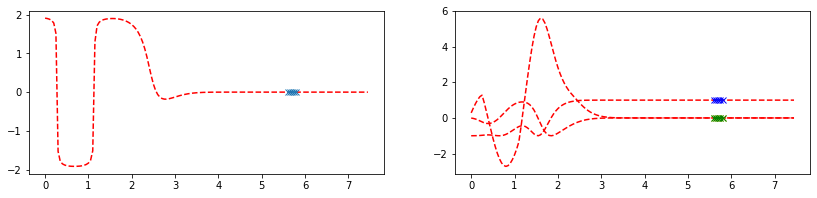

iteration 0 converged 2.2760401322248684e-08 [-0.0000001   0.00000038] [-0.0000002  -0.00000025]
[ 1.         -0.0000001   0.00000038] [ 1.         -0.00000024  0.00000097]


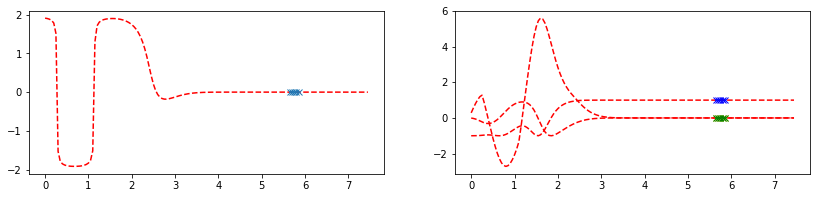

iteration 0 converged 2.276056014797544e-08 [-0.00000008  0.00000034] [-0.0000001  -0.00000014]
[ 1.         -0.00000008  0.00000034] [ 1.         -0.00000019  0.00000078]


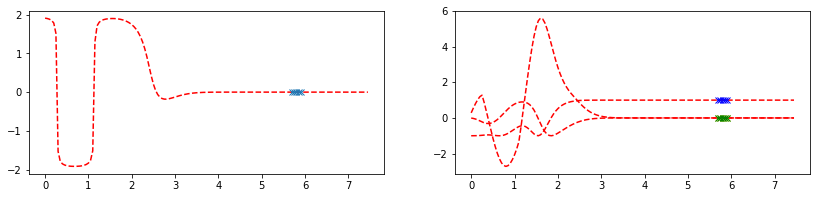

iteration 0 converged 2.2760264499316233e-08 [-0.00000006  0.0000003 ] [-0.00000004 -0.00000007]
[ 1.         -0.00000006  0.0000003 ] [ 1.         -0.00000016  0.00000064]


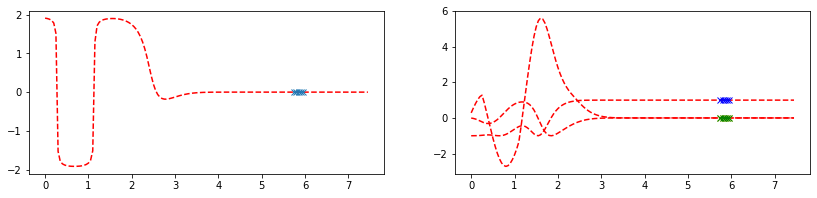

iteration 0 converged 2.2758598231312836e-08 [-0.00000008  0.00000012] [-0.00000021 -0.00000027]
[ 1.         -0.00000008  0.00000012] [ 1.         -0.00000013  0.00000047]


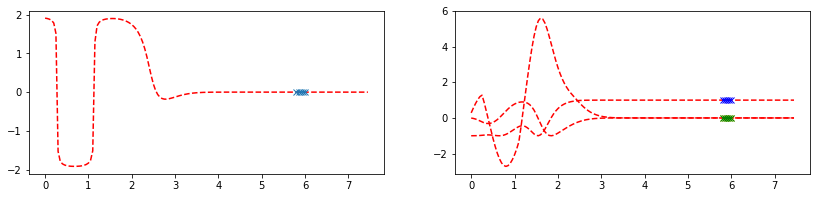

iteration 0 converged 2.2758571698576313e-08 [-0.00000007  0.00000012] [-0.00000041 -0.00000025]
[ 1.         -0.00000007  0.00000012] [ 1.         -0.00000011  0.00000026]


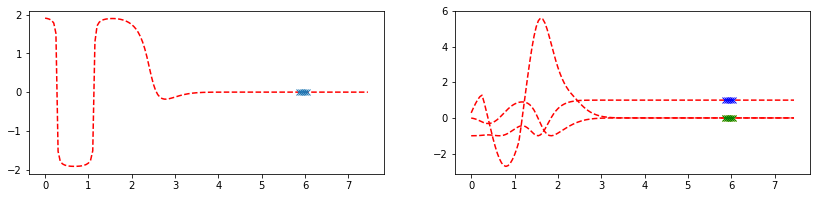

iteration 0 converged 2.2758552090332793e-08 [-0.00000007  0.00000008] [-0.00000027 -0.0000003 ]
[ 1.         -0.00000007  0.00000008] [ 1.        -0.0000001  0.0000001]


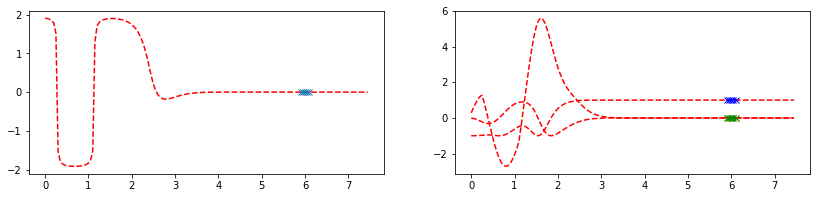

iteration 0 converged 2.275858962431013e-08 [-0.00000007  0.00000004] [-0.         -0.00000013]
[ 1.         -0.00000007  0.00000004] [ 1.         -0.0000001   0.00000002]


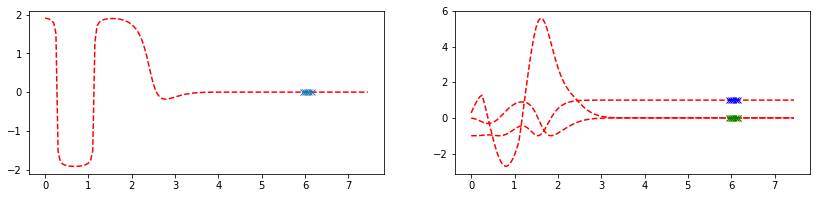

iteration 0 converged 2.2758648126279274e-08 [-0.00000007  0.00000002] [ 0.00000015 -0.00000004]
[ 1.         -0.00000007  0.00000002] [ 1.         -0.0000001  -0.00000001]


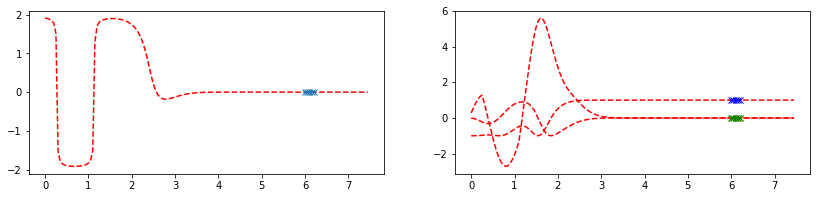

iteration 0 converged 2.2758683764706017e-08 [-0.00000007  0.        ] [ 0.00000023 -0.        ]
[ 1.         -0.00000007  0.        ] [ 1.         -0.0000001  -0.00000001]


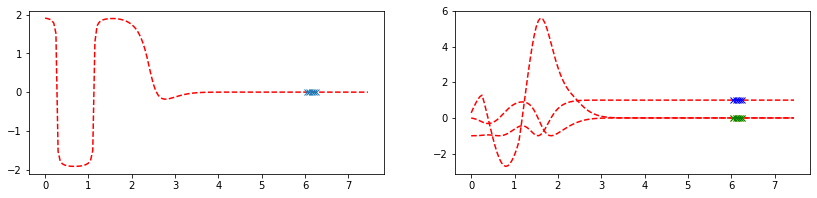

iteration 0 converged 2.2758697246746843e-08 [-0.00000007 -0.00000001] [0.00000026 0.00000001]
[ 1.         -0.00000007 -0.00000001] [ 1.         -0.0000001  -0.00000001]


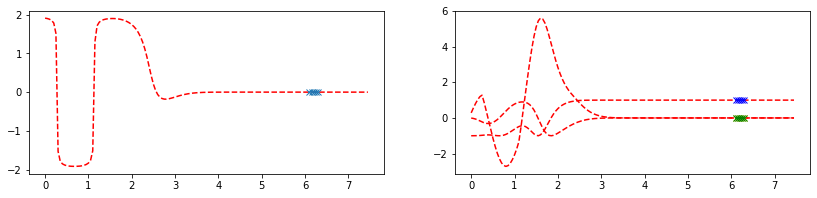

iteration 0 converged 2.2758697283755685e-08 [-0.00000007 -0.00000001] [0.00000027 0.00000001]
[ 1.         -0.00000007 -0.00000001] [ 1.        -0.0000001 -0.       ]


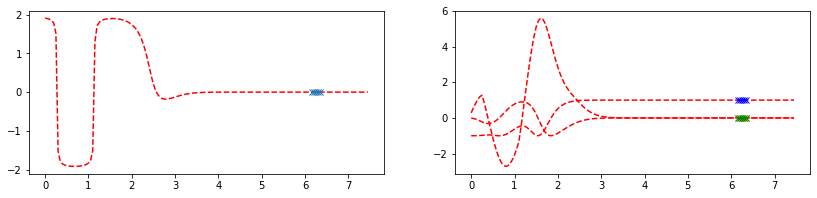

iteration 0 converged 2.2758690963522268e-08 [-0.00000007 -0.00000002] [0.00000027 0.00000001]
[ 1.         -0.00000007 -0.00000002] [ 1.        -0.0000001  0.       ]


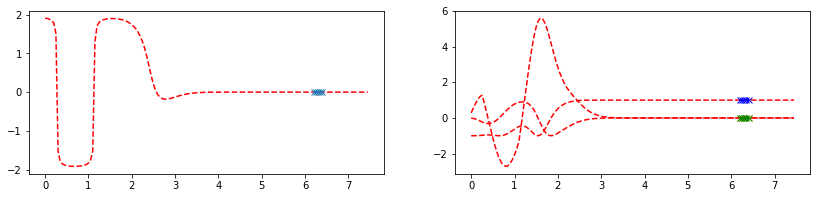

iteration 0 converged 2.2758682524600175e-08 [-0.00000007 -0.00000002] [0.00000026 0.00000001]
[ 1.         -0.00000007 -0.00000002] [ 1.        -0.0000001  0.       ]


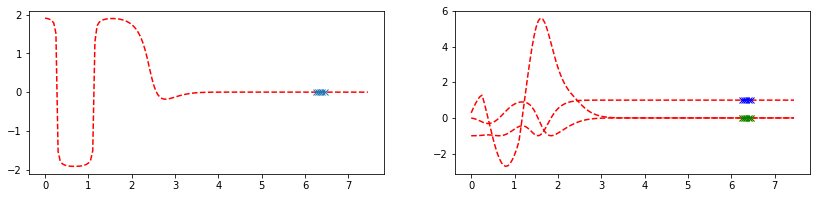

iteration 0 converged 2.275867412555861e-08 [-0.00000007 -0.00000002] [0.00000026 0.        ]
[ 1.         -0.00000007 -0.00000002] [ 1.         -0.0000001   0.00000001]


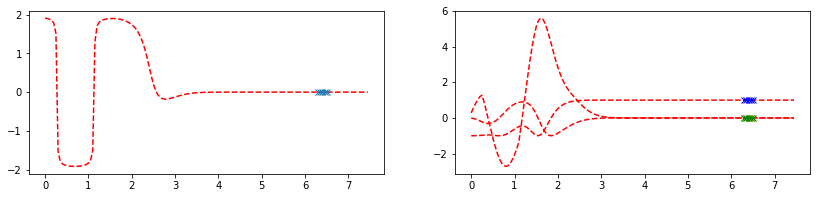

iteration 0 converged 2.275866670983988e-08 [-0.00000007 -0.00000002] [ 0.00000025 -0.        ]
[ 1.         -0.00000007 -0.00000002] [ 1.         -0.0000001   0.00000001]


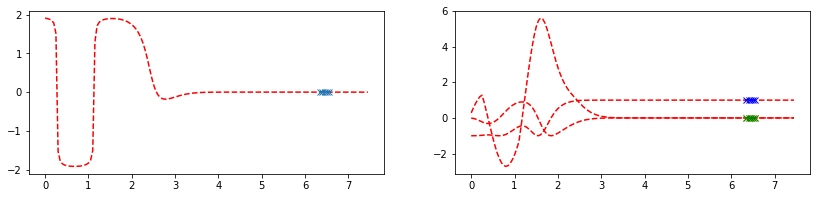

iteration 0 converged 2.2758660585148058e-08 [-0.00000007 -0.00000001] [ 0.00000025 -0.        ]
[ 1.         -0.00000007 -0.00000001] [ 1.         -0.0000001   0.00000001]


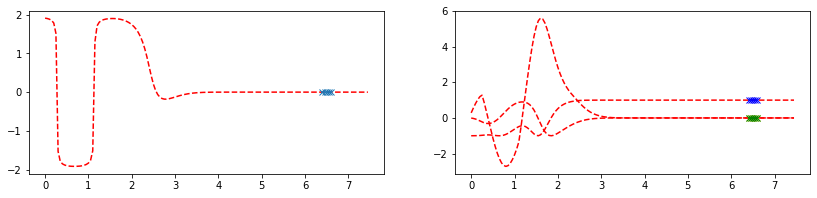

iteration 0 converged 2.2758655748279025e-08 [-0.00000007 -0.00000001] [ 0.00000025 -0.        ]
[ 1.         -0.00000007 -0.00000001] [ 1.         -0.0000001   0.00000001]


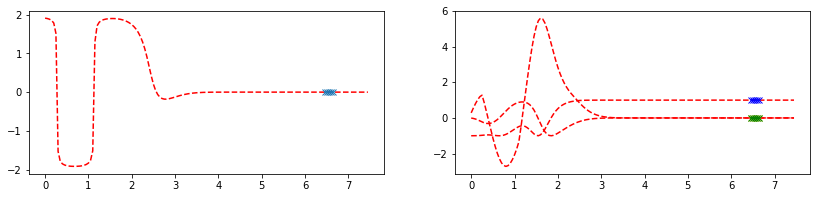

iteration 0 converged 2.2758652052445425e-08 [-0.00000007 -0.        ] [0.00000025 0.        ]
[ 1.         -0.00000007 -0.        ] [ 1.         -0.0000001   0.00000001]


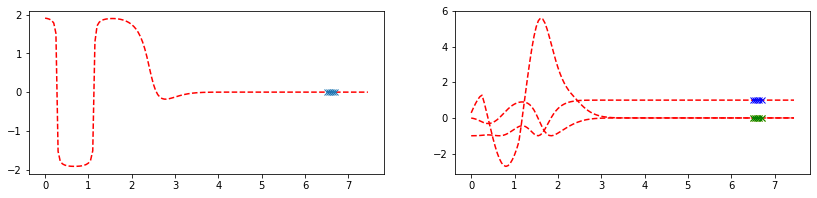

iteration 0 converged 2.275864929168888e-08 [-0.00000006  0.        ] [0.00000025 0.        ]
[ 1.         -0.00000006  0.        ] [ 1.         -0.0000001   0.00000001]


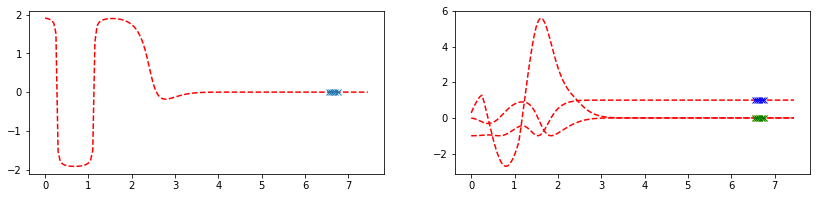

iteration 0 converged 2.2758647245129474e-08 [-0.00000006  0.00000001] [0.00000025 0.00000001]
[ 1.         -0.00000006  0.00000001] [ 1.         -0.0000001   0.00000001]


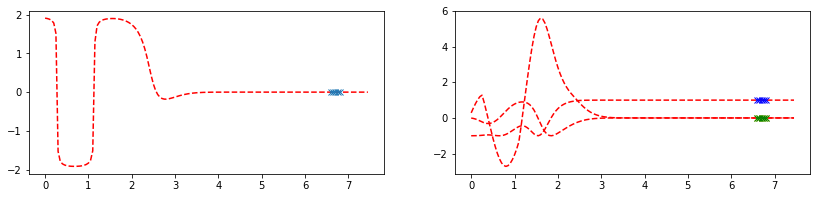

iteration 0 converged 2.275864570049918e-08 [-0.00000006  0.00000002] [0.00000026 0.00000001]
[ 1.         -0.00000006  0.00000002] [ 1.         -0.0000001   0.00000002]


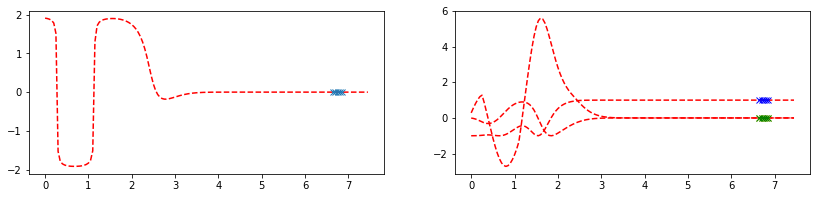

iteration 0 converged 2.2758644469678023e-08 [-0.00000006  0.00000003] [0.00000026 0.00000001]
[ 1.         -0.00000006  0.00000003] [ 1.         -0.0000001   0.00000002]


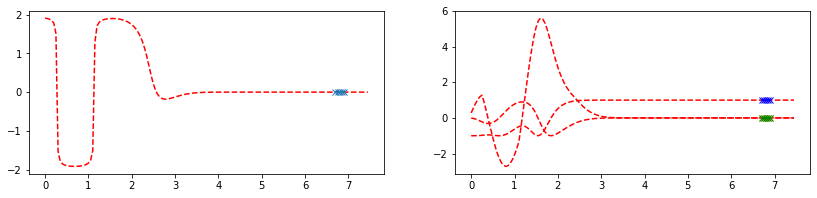

iteration 0 converged 2.2758643396525505e-08 [-0.00000006  0.00000004] [0.00000026 0.00000001]
[ 1.         -0.00000006  0.00000004] [ 1.         -0.0000001   0.00000003]


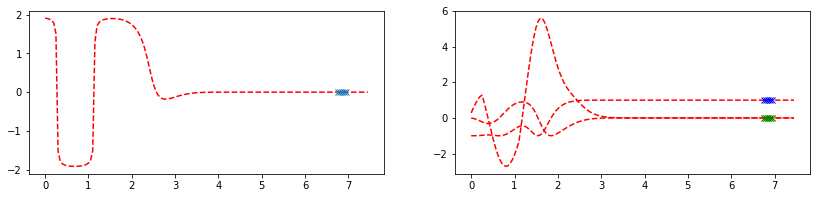

iteration 0 converged 2.2758642363798732e-08 [-0.00000005  0.00000004] [0.00000026 0.00000002]
[ 1.         -0.00000005  0.00000004] [ 1.         -0.00000009  0.00000004]


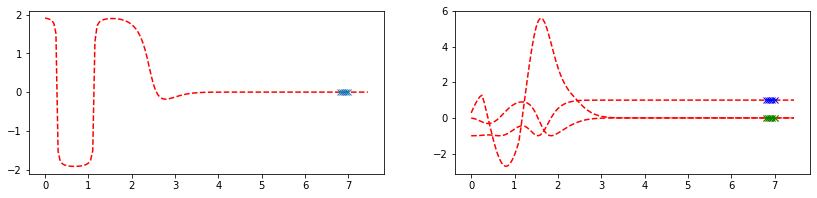

iteration 0 converged 2.2758641297080607e-08 [-0.00000005  0.00000005] [0.00000026 0.00000002]
[ 1.         -0.00000005  0.00000005] [ 1.         -0.00000009  0.00000004]


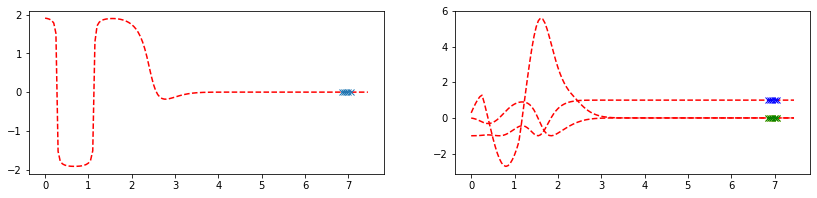

iteration 0 converged 2.275864016810612e-08 [-0.00000005  0.00000006] [0.00000026 0.00000001]
[ 1.         -0.00000005  0.00000006] [ 1.         -0.00000009  0.00000005]


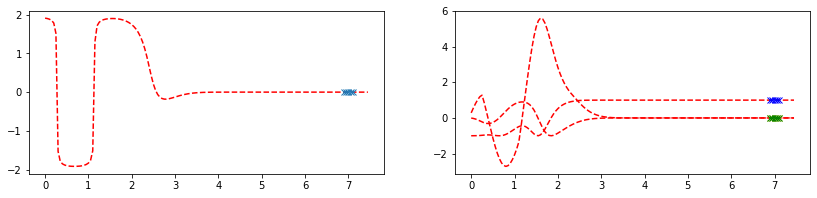

iteration 0 converged 2.2758639002115004e-08 [-0.00000004  0.00000007] [0.00000025 0.00000001]
[ 1.         -0.00000004  0.00000007] [ 1.         -0.00000009  0.00000006]


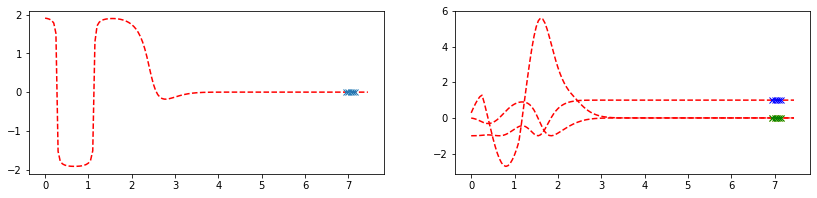

iteration 0 converged 2.2758637886423353e-08 [-0.00000004  0.00000007] [0.00000025 0.00000001]
[ 1.         -0.00000004  0.00000007] [ 1.         -0.00000008  0.00000007]


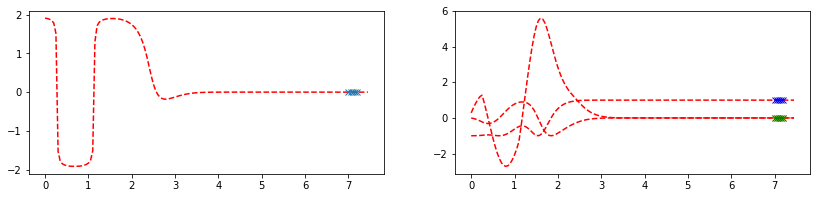

iteration 0 converged 2.275863698638839e-08 [-0.00000003  0.00000007] [ 0.00000024 -0.        ]
[ 1.         -0.00000003  0.00000007] [ 1.         -0.00000008  0.00000008]


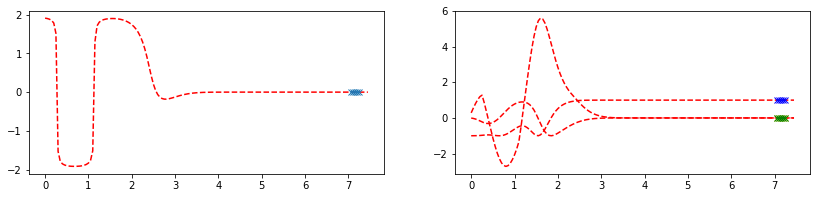

iteration 0 converged 2.2758636570468056e-08 [-0.00000003  0.00000006] [ 0.00000022 -0.00000001]
[ 1.         -0.00000003  0.00000006] [ 1.         -0.00000008  0.00000009]


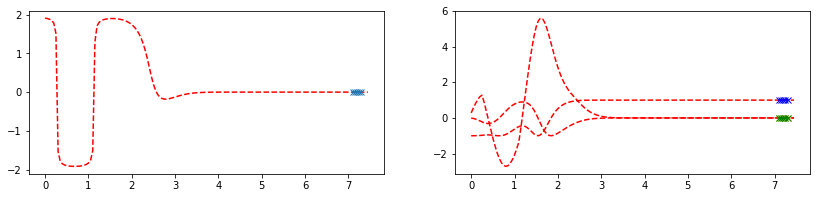

iteration 0 converged 2.2758637049616737e-08 [-0.00000003  0.00000005] [ 0.0000002  -0.00000003]
[ 1.         -0.00000003  0.00000005] [ 1.         -0.00000007  0.0000001 ]


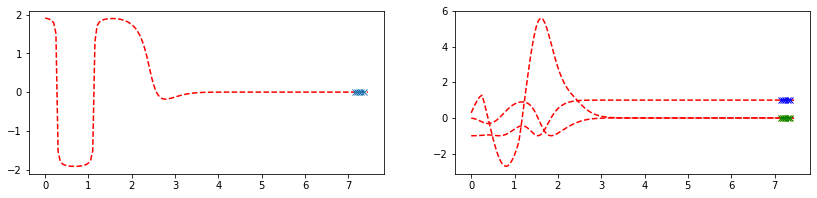

In [24]:
horizon = 5
all_obs = []
all_action = []

obs0, _ = env.reset(init_state)
action = us_constrain[0]
cur_obs = obs0
all_obs.append(cur_obs)

dynamics.min_bound = -2
dynamics.max_bound = 2

for i in range(total_N-1-horizon):
    cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=xs[i+horizon])
    ilqr = iLQR(dynamics, cost, horizon)
    next_xs, next_us = ilqr.fit(cur_obs, us[i:i+horizon], n_iterations=100, on_iteration=on_iteration)
    
    action =  constrain(next_us, -2., 2.)[0]
    
    next_obs, reward, done, info = env.step(action)
    env.render()
    
    print(next_xs[-1], next_obs)
    
    # Plot here
    fig = plt.figure(figsize=(14, 3))
    plt.subplots_adjust(hspace=0.4)

    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    ax1.plot(t, us_constrain, 'r--')  # Ref action
    ax1.plot(t[i: i+horizon],
             constrain(next_us, -2., 2.)[:, 0],
             'x-')  # On going optimisatoin
    
    ax2.plot(t, xs[1:], 'r--')  # Ref traj
    ax2.plot(t[i: i+horizon], next_xs[1:, 0], 'bx-')  # Ref traj
    ax2.plot(t[i: i+horizon], next_xs[1:, 1], 'yx-')  # Ref traj
    ax2.plot(t[i: i+horizon], next_xs[1:, 2], 'gx-')  # Ref traj
    plt.show()
    
    all_obs.append(cur_obs)
    all_action.append(action)
    cur_obs = next_obs
    
env.close()

In [23]:
env.close()